In [2]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import pyam
import pandas as pd
import sys
sys.path.append('/Users/stuartjenkins/Documents/$$Work/2019:02:01 - Carbon budgets with CO2-fe paper')
from fair_scm import *



# from scipy.stats import lognorm
# from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from scipy.ndimage.filters import gaussian_filter

<IPython.core.display.Javascript object>

In [3]:
# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
co2_ems_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx', encoding='utf-8')
co2_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx', encoding='utf-8')
total_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_lower_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx', encoding='utf-8')
two_lower_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx', encoding='utf-8')
two_lower_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_higher_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx', encoding='utf-8')
two_higher_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx', encoding='utf-8')
two_higher_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx', encoding='utf-8')

# import RCP85 scenario to stitch onto past
RCP85_E = pd.read_csv('../RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP85_RF = pd.read_csv('../RCP_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP3_E = pd.read_csv('../RCP_data/RCP3PD_EMISSIONS.csv',skiprows=36,index_col=0)
RCP3_RF = pd.read_csv('../RCP_data/RCP3PD_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP45_E = pd.read_csv('../RCP_data/RCP45_EMISSIONS.csv',skiprows=36,index_col=0)
RCP45_RF = pd.read_csv('../RCP_data/RCP45_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP6_E = pd.read_csv('../RCP_data/RCP6_EMISSIONS.csv',skiprows=36,index_col=0)
RCP6_RF = pd.read_csv('../RCP_data/RCP6_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx`


In [4]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2018
non_co2_forcing_average_over = 10

fbar_s = np.array([])
f0_s = np.array([])
f1_s = np.array([])
delta_fs = np.array([])

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.6
ECS_val = 2.75
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])
gamma = (1 - np.exp(-epsilon*H))/(epsilon*H)

# magicc like AGWP value
r0 = 32.4 # 33.6
rC = 0.019 # 0.0206
rT = 4.165 # 4.635

base_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems[year_val-1765] += 1. * 12 / 44

other_rf = RCP3_RF.TOTAL_ANTHRO_RF.values - RCP3_RF.CO2_RF.values

C_pulse, T_pulse = fair_scm(emissions=pulse_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)
C_base, T_base = fair_scm(emissions=base_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)

RF_net = (F_2x * np.log(C_pulse / C_0) / np.log(2.0)) - (F_2x * np.log(C_base / C_0) / np.log(2.0))
AGWP_CO2 = sp.integrate.simps(RF_net[year_val-1765:year_val+101-1765])
TCRE = (((H / AGWP_CO2) * (F_2x / TCR_val)) * (12 / 44000))**-1
print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')
print(H/AGWP_CO2)

TCR:  1.6 K
ECS:  2.75 K
calculated TCRE:  1.324006450562502 K/TtC
1184.7581636131479


INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc_15_compatible_allthings.xlsx`


0 0
1 2
1 3
4 0
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
6 0
6 1
12 3
12 4
12 5
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
14 15
14 16
16 0
Cumulative CO2 ems (GtCO2), 50: 540.333429102
Cumulative CO2 ems (GtCO2), 25: 459.22043658009994
Cumulative CO2 ems (GtCO2), 75: 652.6937540963
Cumulative stock CH4 ems (GtCO2), 50: 28.455418594330872
Cumulative stock CH4 ems (GtCO2), 25: 19.84406625376325
Cumulative stock CH4 ems (GtCO2), 75: 33.13937873038221
Cumulative flow CH4 ems (GtCO2), 50: -19.057240151621677
Cumulative flow CH4 ems (GtCO2), 25: -59.17777948143389
Cumulative flow CH4 ems (GtCO2), 75: -17.38481015112173
Cumulative N2O ems (GtCO2), 50: 54.269292180709996
Cumulative N2O ems (GtCO2), 25: 43.225588105074
Cumulative N2O ems (GtCO2), 75: 66.633241500895
Cumulative stock F-Gases ems (GtCO2), 50: 3.637830124605217
Cumulative stock F-Gases ems (GtCO2), 25: 2.6186376276982495
Cumulative stock F-Gases ems (GtCO2), 75: 4.621774167850961
Cumulative flow F-Gases ems (GtCO2), 50: 2

Mean of empty slice.
invalid value encountered in double_scalars
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.


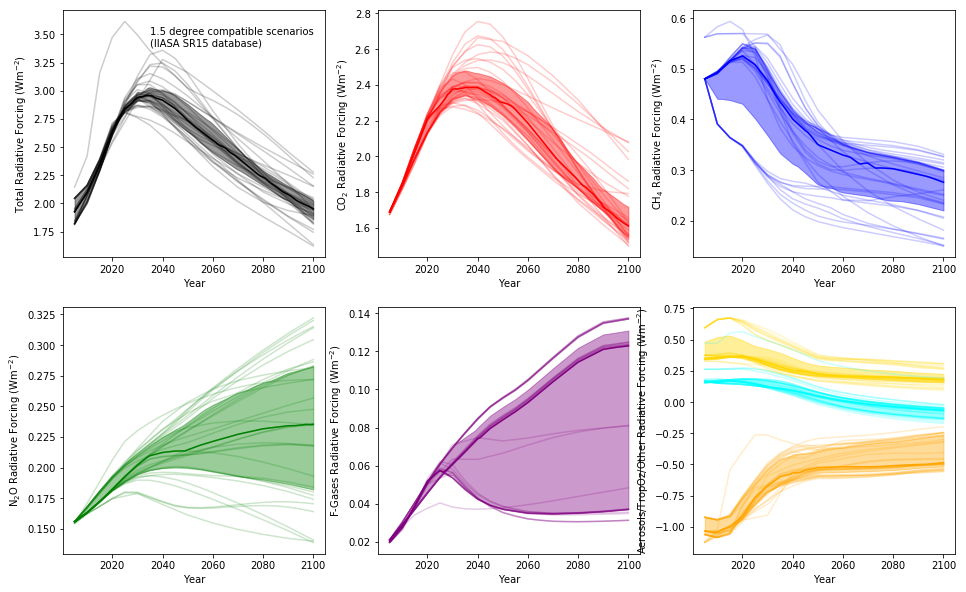

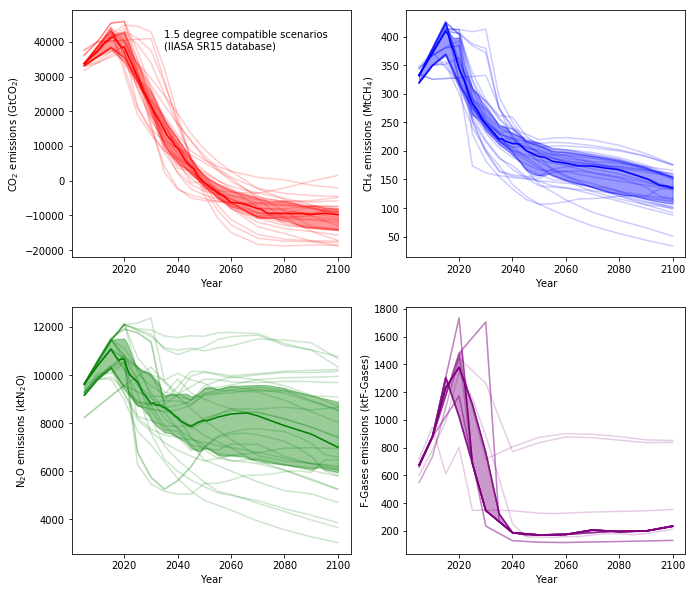

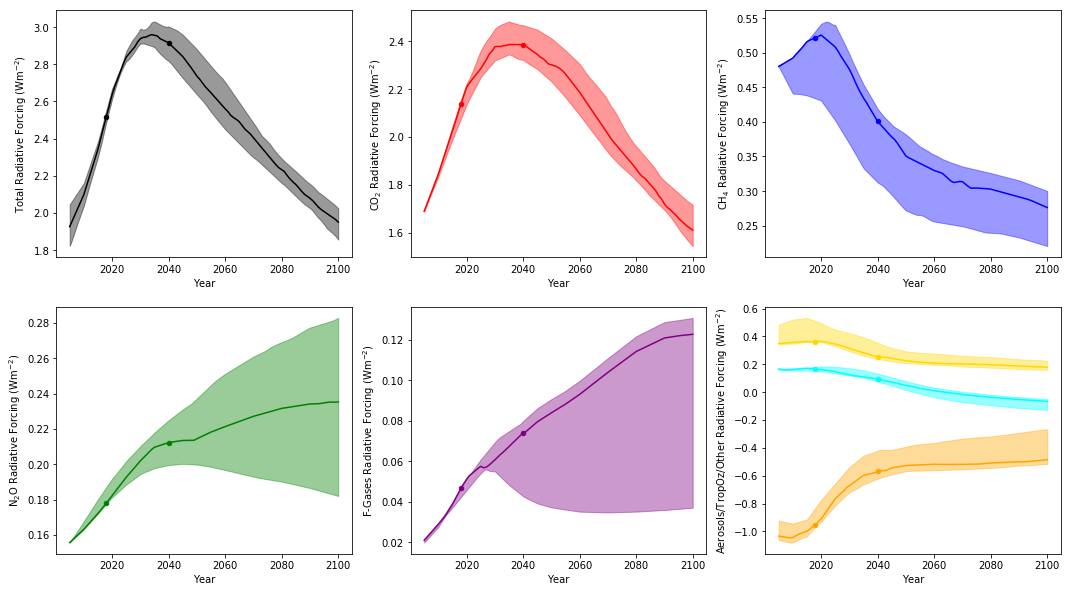

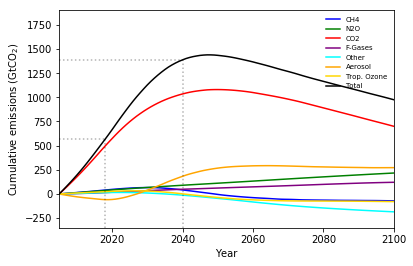

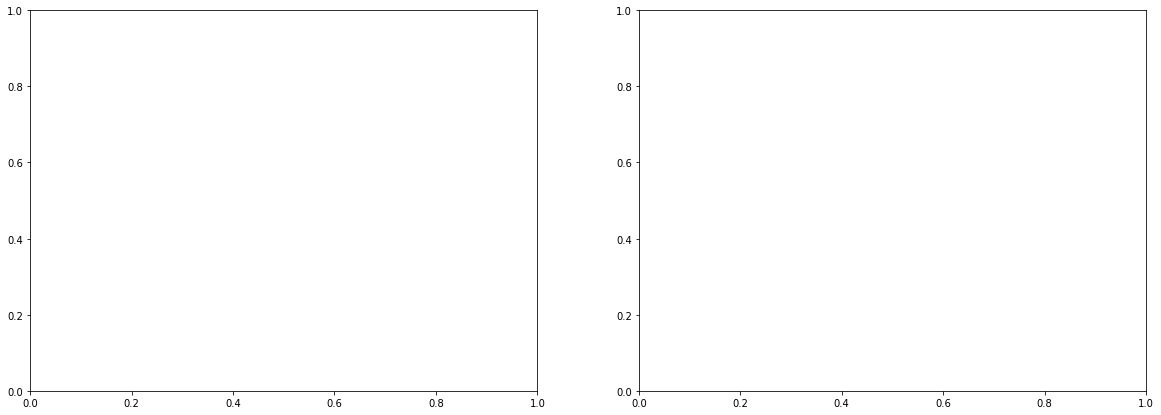

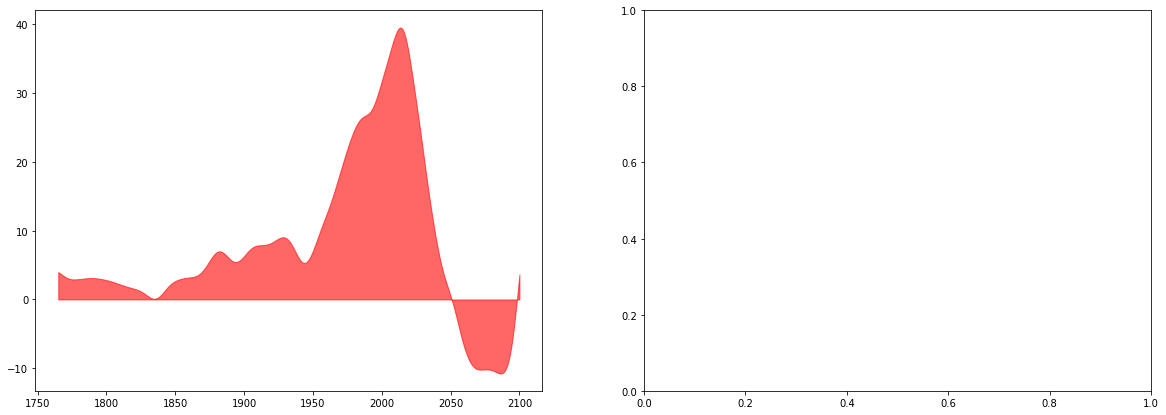

In [5]:
# with CO2-fe ems instead

TCRE_value = 1.4*0.001*12/44

H = 100.0
AGWP_CO2 = H/1090.0

GWP_N2O = 265.0

fig, ax = plt.subplots(2,3,figsize=(16,10))
fig2, ax2 = plt.subplots(2,2,figsize=(11,10))
fig3, ax3 = plt.subplots(2,3,figsize=(18,10))

forcing_splits_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc_15_compatible_allthings.xlsx', encoding='utf-8')

# forcing_splits_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc_15_compatible_forcing_ems_splits.xlsx', encoding='utf-8')

total_rf_15_interp = np.zeros((31,96))
co2_rf_15_interp = np.zeros((31,96))
ch4_rf_15_interp = np.zeros((31,96))
n2o_rf_15_interp = np.zeros((31,96))
fgases_rf_15_interp = np.zeros((31,96))
other_rf_15_interp = np.zeros((31,96))
aerosol_rf_15_interp = np.zeros((31,96))
tropOz_rf_15_interp = np.zeros((31,96))

co2_ems_15_interp = np.zeros((31,96))
ch4_ems_15_interp = np.zeros((31,96))
n2o_ems_15_interp = np.zeros((31,96))
fgases_ems_15_interp = np.zeros((31,96))
l = 0

# i = 0, j = 0
# i = 1, j = 2,3
# i = 2, j = none
# i = 3, j = none
# i = 4, j = 0,2,3,4,5,6,7,8,9
# i = 5, j = none
# i = 6, j = 0,1
# i = 7, j = none
# i = 8, j = none
# i = 9, j = none
# i = 10, j = none
# i = 11, j = none
# i = 12, j = 3,4,5
# i = 13, j = none
# i = 14, j = 4,5,6,7,8,9,10,11,12,13,14,15,16
# i = 15, j = none
# i = 16, j = 0
# i = 17, j = none

colors= ['red','orange','yellow','green','blue','darkblue','purple','gray','black','magenta','cyan','lime','pink','violet','indigo','orangered','royalblue']

possible_js = [[0],[2,3],[0,2,3,4,5,6,7,8,9],[0,1],[3,4,5],[4,5,6,7,8,9,10,11,12,13,14,15,16],[0]]

for k,i in enumerate([0,1,4,6,12,14,16]):
    for j in possible_js[k]:
        print(i, j)
        if i != 0:
            forcing_total = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_CO2 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|CO2').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_CH4 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|CH4').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_N2O = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|N2O').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_fgases = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|F-Gases').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_aerosol = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|Aerosol').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_tropOz = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|Tropospheric Ozone').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            forcing_other = forcing_total - forcing_CO2 - forcing_CH4 - forcing_N2O - forcing_fgases - forcing_aerosol - forcing_tropOz

            ems_CO2 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|CO2').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            ems_CH4 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|CH4').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            ems_N2O = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|N2O').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            ems_fgases = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|F-Gases').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
        else:
            forcing_total = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_CO2 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|CO2').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_CH4 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|CH4').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_N2O = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|N2O').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_fgases = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|F-Gases').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_aerosol = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|Aerosol').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_tropOz = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Forcing|Tropospheric Ozone').as_pandas().set_index('year').loc[[2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]].reindex(range(2005,2101)).interpolate().value
            forcing_other = forcing_total - forcing_CO2 - forcing_CH4 - forcing_N2O - forcing_fgases - forcing_aerosol - forcing_tropOz
            
            ems_CO2 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|CO2').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            ems_CH4 = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|CH4').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            ems_N2O = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|N2O').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            ems_fgases = forcing_splits_df.filter(model=list(forcing_splits_df.models())[i], scenario=list(forcing_splits_df.filter(model=list(forcing_splits_df.models())[i]).scenarios())[j], variable='Emissions|F-Gases').as_pandas().set_index('year').reindex(range(2005,2101)).interpolate().value
            
        ax[0,0].plot(forcing_total, color='black', alpha=0.2)
        ax[0,1].plot(forcing_CO2, color='red', alpha=0.2)
        ax[0,2].plot(forcing_CH4, color='blue', alpha=0.2)
        ax[1,0].plot(forcing_N2O, color='green', alpha=0.2)
        ax[1,1].plot(forcing_fgases, color='purple', alpha=0.2)
        ax[1,2].plot(forcing_other, color='cyan', alpha=0.2)
        ax[1,2].plot(forcing_aerosol, color='orange', alpha=0.2)
        ax[1,2].plot(forcing_tropOz, color='gold', alpha=0.2)
        
        ax2[0,0].plot(ems_CO2, color='red', alpha=0.2)
        ax2[0,1].plot(ems_CH4, color='blue', alpha=0.2)
        ax2[1,0].plot(ems_N2O, color='green', alpha=0.2)
        ax2[1,1].plot(ems_fgases, color='purple', alpha=0.2)
        
        total_rf_15_interp[l,:] = forcing_total.values
        co2_rf_15_interp[l,:] = forcing_CO2.values
        ch4_rf_15_interp[l,:] = forcing_CH4.values
        n2o_rf_15_interp[l,:] = forcing_N2O.values
        fgases_rf_15_interp[l,:] = forcing_fgases.values
        other_rf_15_interp[l,:] = forcing_other.values
        aerosol_rf_15_interp[l,:] = forcing_aerosol.values
        tropOz_rf_15_interp[l,:] = forcing_tropOz.values

        co2_ems_15_interp[l,:] = ems_CO2.values
        ch4_ems_15_interp[l,:] = ems_CH4.values
        n2o_ems_15_interp[l,:] = ems_N2O.values
        fgases_ems_15_interp[l,:] = ems_fgases.values
            
        l += 1

total_rf_50 = np.percentile(total_rf_15_interp, 50, axis = 0)
co2_rf_50 = np.percentile(co2_rf_15_interp, 50, axis = 0)
ch4_rf_50 = np.percentile(ch4_rf_15_interp, 50, axis = 0)
n2o_rf_50 = np.percentile(n2o_rf_15_interp, 50, axis = 0)
fgases_rf_50 = np.percentile(fgases_rf_15_interp, 50, axis = 0)
other_rf_50 = np.percentile(other_rf_15_interp, 50, axis = 0)
aerosol_rf_50 = np.percentile(aerosol_rf_15_interp, 50, axis = 0)
tropOz_rf_50 = np.percentile(tropOz_rf_15_interp, 50, axis = 0)

co2_ems_50 = np.percentile(co2_ems_15_interp, 50, axis = 0)
ch4_ems_50 = np.percentile(ch4_ems_15_interp, 50, axis = 0)
n2o_ems_50 = np.percentile(n2o_ems_15_interp, 50, axis = 0)
fgases_ems_50 = np.percentile(fgases_ems_15_interp[7:-3,:], 50, axis = 0)

total_rf_75 = np.percentile(total_rf_15_interp, 75, axis = 0)
co2_rf_75 = np.percentile(co2_rf_15_interp, 75, axis = 0)
ch4_rf_75 = np.percentile(ch4_rf_15_interp, 75, axis = 0)
n2o_rf_75 = np.percentile(n2o_rf_15_interp, 75, axis = 0)
fgases_rf_75 = np.percentile(fgases_rf_15_interp, 75, axis = 0)
other_rf_75 = np.percentile(other_rf_15_interp, 75, axis = 0)
aerosol_rf_75 = np.percentile(aerosol_rf_15_interp, 75, axis = 0)
tropOz_rf_75 = np.percentile(tropOz_rf_15_interp, 75, axis = 0)

co2_ems_75 = np.percentile(co2_ems_15_interp, 75, axis = 0)
ch4_ems_75 = np.percentile(ch4_ems_15_interp, 75, axis = 0)
n2o_ems_75 = np.percentile(n2o_ems_15_interp, 75, axis = 0)
fgases_ems_75 = np.percentile(fgases_ems_15_interp[7:-3,:], 75, axis = 0)

total_rf_25 = np.percentile(total_rf_15_interp, 25, axis = 0)
co2_rf_25 = np.percentile(co2_rf_15_interp, 25, axis = 0)
ch4_rf_25 = np.percentile(ch4_rf_15_interp, 25, axis = 0)
n2o_rf_25 = np.percentile(n2o_rf_15_interp, 25, axis = 0)
fgases_rf_25 = np.percentile(fgases_rf_15_interp, 25, axis = 0)
other_rf_25 = np.percentile(other_rf_15_interp, 25, axis = 0)
aerosol_rf_25 = np.percentile(aerosol_rf_15_interp, 25, axis = 0)
tropOz_rf_25 = np.percentile(tropOz_rf_15_interp, 25, axis = 0)

co2_ems_25 = np.percentile(co2_ems_15_interp, 25, axis = 0)
ch4_ems_25 = np.percentile(ch4_ems_15_interp, 25, axis = 0)
n2o_ems_25 = np.percentile(n2o_ems_15_interp, 25, axis = 0)
fgases_ems_25 = np.percentile(fgases_ems_15_interp[7:-3,:], 25, axis = 0)

ax[0,0].plot(np.arange(2005,2101), total_rf_50, color='black')
ax[0,0].fill_between(np.arange(2005,2101), total_rf_25, total_rf_75, color='black', alpha=0.4)
ax[0,1].plot(np.arange(2005,2101), co2_rf_50, color='red')
ax[0,1].fill_between(np.arange(2005,2101), co2_rf_25, co2_rf_75, color='red', alpha=0.4)
ax[0,2].plot(np.arange(2005,2101), ch4_rf_50, color='blue')
ax[0,2].fill_between(np.arange(2005,2101), ch4_rf_25, ch4_rf_75, color='blue', alpha=0.4)
ax[1,0].plot(np.arange(2005,2101), n2o_rf_50, color='green')
ax[1,0].fill_between(np.arange(2005,2101), n2o_rf_25, n2o_rf_75, color='green', alpha=0.4)
ax[1,1].plot(np.arange(2005,2101), fgases_rf_50, color='purple')
ax[1,1].fill_between(np.arange(2005,2101), fgases_rf_25, fgases_rf_75, color='purple', alpha=0.4)
ax[1,2].plot(np.arange(2005,2101), aerosol_rf_50, color='orange')
ax[1,2].fill_between(np.arange(2005,2101), aerosol_rf_25, aerosol_rf_75, color='orange', alpha=0.4)
ax[1,2].plot(np.arange(2005,2101), tropOz_rf_50, color='gold')
ax[1,2].fill_between(np.arange(2005,2101), tropOz_rf_25, tropOz_rf_75, color='gold', alpha=0.4)
ax[1,2].plot(np.arange(2005,2101), other_rf_50, color='cyan')
ax[1,2].fill_between(np.arange(2005,2101), other_rf_25, other_rf_75, color='cyan', alpha=0.4)

ax2[0,0].plot(np.arange(2005,2101), co2_ems_50, color='red')
ax2[0,0].fill_between(np.arange(2005,2101), co2_ems_25, co2_ems_75, color='red', alpha=0.4)
ax2[0,1].plot(np.arange(2005,2101), ch4_ems_50, color='blue')
ax2[0,1].fill_between(np.arange(2005,2101), ch4_ems_25, ch4_ems_75, color='blue', alpha=0.4)
ax2[1,0].plot(np.arange(2005,2101), n2o_ems_50, color='green')
ax2[1,0].fill_between(np.arange(2005,2101), n2o_ems_25, n2o_ems_75, color='green', alpha=0.4)
ax2[1,1].plot(np.arange(2005,2101), fgases_ems_50, color='purple')
ax2[1,1].fill_between(np.arange(2005,2101), fgases_ems_25, fgases_ems_75, color='purple', alpha=0.4)


co2_rf_50_plushist = np.zeros(2101-1765)
co2_rf_50_plushist[2005-1765:] = co2_rf_50
co2_rf_50_plushist[:2005-1765] = RCP85_RF.CO2_RF.loc[:2004].values * co2_rf_50[0] / RCP85_RF.CO2_RF.loc[2005]
co2_rf_25_plushist = np.zeros(2101-1765)
co2_rf_25_plushist[2005-1765:] = co2_rf_25
co2_rf_25_plushist[:2005-1765] = RCP85_RF.CO2_RF.loc[:2004].values * co2_rf_25[0] / RCP85_RF.CO2_RF.loc[2005]
co2_rf_75_plushist = np.zeros(2101-1765)
co2_rf_75_plushist[2005-1765:] = co2_rf_75
co2_rf_75_plushist[:2005-1765] = RCP85_RF.CO2_RF.loc[:2004].values * co2_rf_75[0] / RCP85_RF.CO2_RF.loc[2005]

ch4_rf_50_plushist = np.zeros(2101-1765)
ch4_rf_50_plushist[2005-1765:] = ch4_rf_50
ch4_rf_50_plushist[:2005-1765] = RCP85_RF.CH4_RF.loc[:2004].values * ch4_rf_50[0] / RCP85_RF.CH4_RF.loc[2005]
ch4_rf_25_plushist = np.zeros(2101-1765)
ch4_rf_25_plushist[2005-1765:] = ch4_rf_25
ch4_rf_25_plushist[:2005-1765] = RCP85_RF.CH4_RF.loc[:2004].values * ch4_rf_25[0] / RCP85_RF.CH4_RF.loc[2005]
ch4_rf_75_plushist = np.zeros(2101-1765)
ch4_rf_75_plushist[2005-1765:] = ch4_rf_75
ch4_rf_75_plushist[:2005-1765] = RCP85_RF.CH4_RF.loc[:2004].values * ch4_rf_75[0] / RCP85_RF.CH4_RF.loc[2005]

n2o_rf_50_plushist = np.zeros(2101-1765)
n2o_rf_50_plushist[2005-1765:] = n2o_rf_50
n2o_rf_50_plushist[:2005-1765] = RCP85_RF.N2O_RF.loc[:2004].values * n2o_rf_50[0] / RCP85_RF.N2O_RF.loc[2005]
n2o_rf_25_plushist = np.zeros(2101-1765)
n2o_rf_25_plushist[2005-1765:] = n2o_rf_25
n2o_rf_25_plushist[:2005-1765] = RCP85_RF.N2O_RF.loc[:2004].values * n2o_rf_25[0] / RCP85_RF.N2O_RF.loc[2005]
n2o_rf_75_plushist = np.zeros(2101-1765)
n2o_rf_75_plushist[2005-1765:] = n2o_rf_75
n2o_rf_75_plushist[:2005-1765] = RCP85_RF.N2O_RF.loc[:2004].values * n2o_rf_75[0] / RCP85_RF.N2O_RF.loc[2005]

fgases_rf_50_plushist = np.zeros(2101-1765)
fgases_rf_50_plushist[2005-1765:] = fgases_rf_50
fgases_rf_50_plushist[:2005-1765] = RCP85_RF.FGASSUM_RF.loc[:2004].values * fgases_rf_50[0] / RCP85_RF.FGASSUM_RF.loc[2005]
fgases_rf_25_plushist = np.zeros(2101-1765)
fgases_rf_25_plushist[2005-1765:] = fgases_rf_25
fgases_rf_25_plushist[:2005-1765] = RCP85_RF.FGASSUM_RF.loc[:2004].values * fgases_rf_25[0] / RCP85_RF.FGASSUM_RF.loc[2005]
fgases_rf_75_plushist = np.zeros(2101-1765)
fgases_rf_75_plushist[2005-1765:] = fgases_rf_75
fgases_rf_75_plushist[:2005-1765] = RCP85_RF.FGASSUM_RF.loc[:2004].values * fgases_rf_75[0] / RCP85_RF.FGASSUM_RF.loc[2005]

# other_rf_50_plushist = np.zeros(2101-1765)
# other_rf_50_plushist[2005-1765:] = other_rf_50
# other_rf_50_plushist[:2005-1765] = (RCP85_RF.TOTAL_ANTHRO_RF.loc[:2004].values - RCP85_RF.CO2CH4N2O_RF.loc[:2004].values - RCP85_RF.FGASSUM_RF.loc[:2004].values - RCP85_RF.TOTAER_DIR_RF.loc[:2004].values) * other_rf_50[0] / (RCP85_RF.TOTAL_ANTHRO_RF.loc[2005] - RCP85_RF.CO2CH4N2O_RF.loc[2005] - RCP85_RF.FGASSUM_RF.loc[2005] - RCP85_RF.TOTAER_DIR_RF.loc[2005])
# other_rf_25_plushist = np.zeros(2101-1765)
# other_rf_25_plushist[2005-1765:] = other_rf_25
# other_rf_25_plushist[:2005-1765] = (RCP85_RF.TOTAL_ANTHRO_RF.loc[:2004].values - RCP85_RF.CO2CH4N2O_RF.loc[:2004].values - RCP85_RF.FGASSUM_RF.loc[:2004].values - RCP85_RF.TOTAER_DIR_RF.loc[:2004].values) * other_rf_50[0] / (RCP85_RF.TOTAL_ANTHRO_RF.loc[2005] - RCP85_RF.CO2CH4N2O_RF.loc[2005] - RCP85_RF.FGASSUM_RF.loc[2005] - RCP85_RF.TOTAER_DIR_RF.loc[2005])
# other_rf_75_plushist = np.zeros(2101-1765)
# other_rf_75_plushist[2005-1765:] = other_rf_75
# other_rf_75_plushist[:2005-1765] = (RCP85_RF.TOTAL_ANTHRO_RF.loc[:2004].values - RCP85_RF.CO2CH4N2O_RF.loc[:2004].values - RCP85_RF.FGASSUM_RF.loc[:2004].values - RCP85_RF.TOTAER_DIR_RF.loc[:2004].values) * other_rf_50[0] / (RCP85_RF.TOTAL_ANTHRO_RF.loc[2005] - RCP85_RF.CO2CH4N2O_RF.loc[2005] - RCP85_RF.FGASSUM_RF.loc[2005] - RCP85_RF.TOTAER_DIR_RF.loc[2005])

other_rf_50_plushist = np.zeros(2101-1765)
other_rf_50_plushist[2005-1765:] = other_rf_50 
other_rf_50_plushist[:2005-1765] = (np.arange(0,2005-1765)**2)*other_rf_50[0]/(((2005-1765)**2)*(8/7)) + np.arange(0,2005-1765)*other_rf_50[0]/((2005-1765)*(8))
other_rf_25_plushist = np.zeros(2101-1765)
other_rf_25_plushist[2005-1765:] = other_rf_25 
other_rf_25_plushist[:2005-1765] = (np.arange(0,2005-1765)**2)*other_rf_25[0]/(((2005-1765)**2)*(8/7)) + np.arange(0,2005-1765)*other_rf_25[0]/((2005-1765)*(8))
other_rf_75_plushist = np.zeros(2101-1765)
other_rf_75_plushist[2005-1765:] = other_rf_75
other_rf_75_plushist[:2005-1765] = (np.arange(0,2005-1765)**2)*other_rf_75[0]/(((2005-1765)**2)*(8/7)) + np.arange(0,2005-1765)*other_rf_75[0]/((2005-1765)*(8))

aerosol_rf_50_plushist = np.zeros(2101-1765)
aerosol_rf_50_plushist[2005-1765:] = aerosol_rf_50
aerosol_rf_50_plushist[:2005-1765] = RCP85_RF.TOTAER_DIR_RF.loc[:2004].values * aerosol_rf_50[0] / RCP85_RF.TOTAER_DIR_RF.loc[2005]
aerosol_rf_25_plushist = np.zeros(2101-1765)
aerosol_rf_25_plushist[2005-1765:] = aerosol_rf_25
aerosol_rf_25_plushist[:2005-1765] = RCP85_RF.TOTAER_DIR_RF.loc[:2004].values * aerosol_rf_25[0] / RCP85_RF.TOTAER_DIR_RF.loc[2005]
aerosol_rf_75_plushist = np.zeros(2101-1765)
aerosol_rf_75_plushist[2005-1765:] = aerosol_rf_75
aerosol_rf_75_plushist[:2005-1765] = RCP85_RF.TOTAER_DIR_RF.loc[:2004].values * aerosol_rf_75[0] / RCP85_RF.TOTAER_DIR_RF.loc[2005]

tropOz_rf_50_plushist = np.zeros(2101-1765)
tropOz_rf_50_plushist[2005-1765:] = tropOz_rf_50
tropOz_rf_50_plushist[:2005-1765] = RCP85_RF.TROPOZ_RF.loc[:2004].values * tropOz_rf_50[0] / RCP85_RF.TROPOZ_RF.loc[2005]
tropOz_rf_25_plushist = np.zeros(2101-1765)
tropOz_rf_25_plushist[2005-1765:] = tropOz_rf_25
tropOz_rf_25_plushist[:2005-1765] = RCP85_RF.TROPOZ_RF.loc[:2004].values * tropOz_rf_25[0] / RCP85_RF.TROPOZ_RF.loc[2005]
tropOz_rf_75_plushist = np.zeros(2101-1765)
tropOz_rf_75_plushist[2005-1765:] = tropOz_rf_75
tropOz_rf_75_plushist[:2005-1765] = RCP85_RF.TROPOZ_RF.loc[:2004].values * tropOz_rf_75[0] / RCP85_RF.TROPOZ_RF.loc[2005]

total_rf_50_plushist = np.zeros(2101-1765)
total_rf_50_plushist[2005-1765:] = total_rf_50
total_rf_50_plushist[:2005-1765] = RCP85_RF.TOTAL_ANTHRO_RF.loc[:2004].values * total_rf_50[0] / RCP85_RF.TOTAL_ANTHRO_RF.loc[2005]
total_rf_25_plushist = np.zeros(2101-1765)
total_rf_25_plushist[2005-1765:] = total_rf_25
total_rf_25_plushist[:2005-1765] = RCP85_RF.TOTAL_ANTHRO_RF.loc[:2004].values * total_rf_25[0] / RCP85_RF.TOTAL_ANTHRO_RF.loc[2005]
total_rf_75_plushist = np.zeros(2101-1765)
total_rf_75_plushist[2005-1765:] = total_rf_75
total_rf_75_plushist[:2005-1765] = RCP85_RF.TOTAL_ANTHRO_RF.loc[:2004].values * total_rf_75[0] / RCP85_RF.TOTAL_ANTHRO_RF.loc[2005]

T_50 = fair_scm(other_rf=total_rf_50_plushist, tcrecs=np.array([1.75,2.6]))[1]
T_25 = fair_scm(other_rf=total_rf_25_plushist, tcrecs=np.array([1.75,2.6]))[1]
T_75 = fair_scm(other_rf=total_rf_75_plushist, tcrecs=np.array([1.75,2.6]))[1]
year_T_max_50 = np.argmax(T_50)
year_T_max_25 = np.argmax(T_25)
year_T_max_75 = np.argmax(T_75)



ax3[0,0].plot(np.arange(2005,2101), total_rf_50, color='black')
ax3[0,0].fill_between(np.arange(2005,2101), total_rf_25, total_rf_75, color='black', alpha=0.4)
ax3[0,1].plot(np.arange(2005,2101), co2_rf_50, color='red')
ax3[0,1].fill_between(np.arange(2005,2101), co2_rf_25, co2_rf_75, color='red', alpha=0.4)
ax3[0,2].plot(np.arange(2005,2101), ch4_rf_50, color='blue')
ax3[0,2].fill_between(np.arange(2005,2101), ch4_rf_25, ch4_rf_75, color='blue', alpha=0.4)
ax3[1,0].plot(np.arange(2005,2101), n2o_rf_50, color='green')
ax3[1,0].fill_between(np.arange(2005,2101), n2o_rf_25, n2o_rf_75, color='green', alpha=0.4)
ax3[1,1].plot(np.arange(2005,2101), fgases_rf_50, color='purple')
ax3[1,1].fill_between(np.arange(2005,2101), fgases_rf_25, fgases_rf_75, color='purple', alpha=0.4)
ax3[1,2].plot(np.arange(2005,2101), other_rf_50, color='cyan')
ax3[1,2].fill_between(np.arange(2005,2101), other_rf_25, other_rf_75, color='cyan', alpha=0.4)
ax3[1,2].plot(np.arange(2005,2101), aerosol_rf_50, color='orange')
ax3[1,2].fill_between(np.arange(2005,2101), aerosol_rf_25, aerosol_rf_75, color='orange', alpha=0.4)
ax3[1,2].plot(np.arange(2005,2101), tropOz_rf_50, color='gold')
ax3[1,2].fill_between(np.arange(2005,2101), tropOz_rf_25, tropOz_rf_75, color='gold', alpha=0.4)

ax3[0,0].scatter([year_T_max_50+1765],[total_rf_50[year_T_max_50+1765-2005]], color='black', s=20, zorder=101)
ax3[0,1].scatter([year_T_max_50+1765],[co2_rf_50[year_T_max_50+1765-2005]], color='red', s=20, zorder=101)
ax3[0,2].scatter([year_T_max_50+1765],[ch4_rf_50[year_T_max_50+1765-2005]], color='blue', s=20, zorder=101)
ax3[1,0].scatter([year_T_max_50+1765],[n2o_rf_50[year_T_max_50+1765-2005]], color='green', s=20, zorder=101)
ax3[1,1].scatter([year_T_max_50+1765],[fgases_rf_50[year_T_max_50+1765-2005]], color='purple', s=20, zorder=101)
ax3[1,2].scatter([year_T_max_50+1765],[other_rf_50[year_T_max_50+1765-2005]], color='cyan', s=20, zorder=101)
ax3[1,2].scatter([year_T_max_50+1765],[aerosol_rf_50[year_T_max_50+1765-2005]], color='orange', s=20, zorder=101)
ax3[1,2].scatter([year_T_max_50+1765],[tropOz_rf_50[year_T_max_50+1765-2005]], color='gold', s=20, zorder=101)

ax3[0,0].scatter([2018],[total_rf_50[2018-2005]], color='black', s=20, zorder=101)
ax3[0,1].scatter([2018],[co2_rf_50[2018-2005]], color='red', s=20, zorder=101)
ax3[0,2].scatter([2018],[ch4_rf_50[2018-2005]], color='blue', s=20, zorder=101)
ax3[1,0].scatter([2018],[n2o_rf_50[2018-2005]], color='green', s=20, zorder=101)
ax3[1,1].scatter([2018],[fgases_rf_50[2018-2005]], color='purple', s=20, zorder=101)
ax3[1,2].scatter([2018],[other_rf_50[2018-2005]], color='cyan', s=20, zorder=101)
ax3[1,2].scatter([2018],[aerosol_rf_50[2018-2005]], color='orange', s=20, zorder=101)
ax3[1,2].scatter([2018],[tropOz_rf_50[2018-2005]], color='gold', s=20, zorder=101)

ch4_eq_timeseries = np.zeros(2101-2005)
co2_eq_timeseries = np.zeros(2101-2005)
n2o_eq_timeseries = np.zeros(2101-2005)
fgases_eq_timeseries = np.zeros(2101-2005)
other_eq_timeseries = np.zeros(2101-2005)
aerosol_eq_timeseries = np.zeros(2101-2005)
tropOz_eq_timeseries = np.zeros(2101-2005)
for i in range(2006,2101):
    ch4_eq_timeseries[i-2005] = (0.25*np.mean(ch4_rf_50_plushist[i-1765-1:i-1765])*(i-2005) / AGWP_CO2) + (75*(np.mean(ch4_rf_50_plushist[i-1765-20:i-1765+1]) - np.mean(ch4_rf_50_plushist[1985-1765:2005-1765+1])) / AGWP_CO2)
    n2o_eq_timeseries[i-2005] = GWP_N2O * np.sum(n2o_ems_50[:i-2005])/1000000.
    fgases_eq_timeseries[i-2005] = (0.25*np.mean(fgases_rf_50_plushist[i-1765-1:i-1765])*(i-2005) / AGWP_CO2) + (75*(np.mean(fgases_rf_50_plushist[i-1765-20:i-1765+1]) - np.mean(fgases_rf_50_plushist[1985-1765:2005-1765+1])) / AGWP_CO2)
    other_eq_timeseries[i-2005] = (0.25*np.mean(other_rf_50_plushist[i-1765-1:i-1765])*(i-2005) / AGWP_CO2) + (75*(np.mean(other_rf_50_plushist[i-1765-20:i-1765+1]) - np.mean(other_rf_50_plushist[1985-1765:2005-1765+1])) / AGWP_CO2)
    co2_eq_timeseries[i-2005] = np.sum(co2_ems_50[:i-2005])/1000.
    aerosol_eq_timeseries[i-2005] = (0.25*np.mean(aerosol_rf_50_plushist[i-1765-1:i-1765])*(i-2005) / AGWP_CO2) + (75*(np.mean(aerosol_rf_50_plushist[i-1765-20:i-1765+1]) - np.mean(aerosol_rf_50_plushist[1985-1765:2005-1765+1])) / AGWP_CO2)
    tropOz_eq_timeseries[i-2005] = (0.25*np.mean(tropOz_rf_50_plushist[i-1765-1:i-1765])*(i-2005) / AGWP_CO2) + (75*(np.mean(tropOz_rf_50_plushist[i-1765-20:i-1765+1]) - np.mean(tropOz_rf_50_plushist[1985-1765:2005-1765+1])) / AGWP_CO2)
    
plt.figure()
plt.plot(np.arange(2005,2101), ch4_eq_timeseries, color='blue', label='CH4')
plt.plot(np.arange(2005,2101), n2o_eq_timeseries, color='green', label='N2O')
plt.plot(np.arange(2005,2101), co2_eq_timeseries, color='red', label='CO2')
plt.plot(np.arange(2005,2101), fgases_eq_timeseries, color='purple', label='F-Gases')
plt.plot(np.arange(2005,2101), other_eq_timeseries, color='cyan', label='Other')
plt.plot(np.arange(2005,2101), aerosol_eq_timeseries, color='orange', label='Aerosol')
plt.plot(np.arange(2005,2101), tropOz_eq_timeseries, color='gold', label='Trop. Ozone')
total_eq_timeseries = ch4_eq_timeseries+n2o_eq_timeseries+other_eq_timeseries+co2_eq_timeseries+fgases_eq_timeseries+aerosol_eq_timeseries+tropOz_eq_timeseries
plt.plot(np.arange(2005,2101), total_eq_timeseries, color='black', label='Total')
plt.xlabel('Year')
plt.ylabel('Cumulative emissions (GtCO$_2$)')
plt.legend(loc='upper right', edgecolor='white', framealpha=0.0, fontsize = 7)
plt.plot([2018,2018],[-350,total_eq_timeseries[2018-2005]], linestyle=':',color='black',alpha=0.3)
plt.plot([year_T_max_50+1765,year_T_max_50+1765],[-350,total_eq_timeseries[year_T_max_50-2005+1765]], linestyle=':',color='black',alpha=0.3)
plt.plot([2005,2018],[total_eq_timeseries[2018-2005],total_eq_timeseries[2018-2005]], linestyle=':',color='black',alpha=0.3)
plt.plot([2005,year_T_max_50+1765],[total_eq_timeseries[year_T_max_50-2005+1765],total_eq_timeseries[year_T_max_50-2005+1765]], linestyle=':',color='black',alpha=0.3)
plt.xlim(2005,2100)
plt.ylim(-350,1900)
# plt.savefig('15degree_timeseries.pdf',dpi=300)



print('Cumulative CO2 ems (GtCO2), 50:', np.sum(co2_ems_50[2018-2005:year_T_max_50+1765-2005])/1000.)
print('Cumulative CO2 ems (GtCO2), 25:', np.sum(co2_ems_25[2018-2005:year_T_max_25+1765-2005])/1000.)
print('Cumulative CO2 ems (GtCO2), 75:', np.sum(co2_ems_75[2018-2005:year_T_max_75+1765-2005])/1000.)

print('Cumulative stock CH4 ems (GtCO2), 50:', 0.25*np.mean(ch4_rf_50_plushist[2018-1765:year_T_max_50+1])*(year_T_max_50-2018+1765) / AGWP_CO2)
print('Cumulative stock CH4 ems (GtCO2), 25:', 0.25*np.mean(ch4_rf_25_plushist[2018-1765:year_T_max_25+1])*(year_T_max_25-2018+1765) / AGWP_CO2)
print('Cumulative stock CH4 ems (GtCO2), 75:', 0.25*np.mean(ch4_rf_75_plushist[2018-1765:year_T_max_75+1])*(year_T_max_75-2018+1765) / AGWP_CO2)
print('Cumulative flow CH4 ems (GtCO2), 50:', 75*(np.mean(ch4_rf_50_plushist[year_T_max_50-20:year_T_max_50+1]) - np.mean(ch4_rf_50_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow CH4 ems (GtCO2), 25:', 75*(np.mean(ch4_rf_25_plushist[year_T_max_25-20:year_T_max_25+1]) - np.mean(ch4_rf_25_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow CH4 ems (GtCO2), 75:', 75*(np.mean(ch4_rf_75_plushist[year_T_max_75-20:year_T_max_75+1]) - np.mean(ch4_rf_75_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)

print('Cumulative N2O ems (GtCO2), 50:', GWP_N2O * np.sum(n2o_ems_50[2018-2005:year_T_max_50+1765-2005])/1000000.)
print('Cumulative N2O ems (GtCO2), 25:', GWP_N2O * np.sum(n2o_ems_25[2018-2005:year_T_max_25+1765-2005])/1000000.)
print('Cumulative N2O ems (GtCO2), 75:', GWP_N2O * np.sum(n2o_ems_75[2018-2005:year_T_max_75+1765-2005])/1000000.)

print('Cumulative stock F-Gases ems (GtCO2), 50:', 0.25*np.mean(fgases_rf_50_plushist[2018-1765:year_T_max_50+1])*(year_T_max_50-2018+1765) / AGWP_CO2)
print('Cumulative stock F-Gases ems (GtCO2), 25:', 0.25*np.mean(fgases_rf_25_plushist[2018-1765:year_T_max_25+1])*(year_T_max_25-2018+1765) / AGWP_CO2)
print('Cumulative stock F-Gases ems (GtCO2), 75:', 0.25*np.mean(fgases_rf_75_plushist[2018-1765:year_T_max_75+1])*(year_T_max_75-2018+1765) / AGWP_CO2)
print('Cumulative flow F-Gases ems (GtCO2), 50:', 75*(np.mean(fgases_rf_50_plushist[year_T_max_50-20:year_T_max_50+1]) - np.mean(fgases_rf_50_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow F-Gases ems (GtCO2), 25:', 75*(np.mean(fgases_rf_25_plushist[year_T_max_25-20:year_T_max_25+1]) - np.mean(fgases_rf_25_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow F-Gases ems (GtCO2), 75:', 75*(np.mean(fgases_rf_75_plushist[year_T_max_75-20:year_T_max_75+1]) - np.mean(fgases_rf_75_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)

print('Cumulative stock other ems (GtCO2), 50:', 0.25*np.mean(other_rf_50_plushist[2018-1765:year_T_max_50+1])*(year_T_max_50-2018+1765) / AGWP_CO2)
print('Cumulative stock other ems (GtCO2), 25:', 0.25*np.mean(other_rf_25_plushist[2018-1765:year_T_max_25+1])*(year_T_max_25-2018+1765) / AGWP_CO2)
print('Cumulative stock other ems (GtCO2), 75:', 0.25*np.mean(other_rf_75_plushist[2018-1765:year_T_max_75+1])*(year_T_max_75-2018+1765) / AGWP_CO2)
print('Cumulative flow other ems (GtCO2), 50:', 75*(np.mean(other_rf_50_plushist[year_T_max_50-20:year_T_max_50+1]) - np.mean(other_rf_50_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow other ems (GtCO2), 25:', 75*(np.mean(other_rf_25_plushist[year_T_max_25-20:year_T_max_25+1]) - np.mean(other_rf_25_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow other ems (GtCO2), 75:', 75*(np.mean(other_rf_75_plushist[year_T_max_75-20:year_T_max_75+1]) - np.mean(other_rf_75_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)

print('Cumulative stock aerosol ems (GtCO2), 50:', 0.25*np.mean(aerosol_rf_50_plushist[2018-1765:year_T_max_50+1])*(year_T_max_50-2018+1765) / AGWP_CO2)
print('Cumulative stock aerosol ems (GtCO2), 25:', 0.25*np.mean(aerosol_rf_25_plushist[2018-1765:year_T_max_25+1])*(year_T_max_25-2018+1765) / AGWP_CO2)
print('Cumulative stock aerosol ems (GtCO2), 75:', 0.25*np.mean(aerosol_rf_75_plushist[2018-1765:year_T_max_75+1])*(year_T_max_75-2018+1765) / AGWP_CO2)
print('Cumulative flow aerosol ems (GtCO2), 50:', 75*(np.mean(aerosol_rf_50_plushist[year_T_max_50-20:year_T_max_50+1]) - np.mean(aerosol_rf_50_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow aerosol ems (GtCO2), 25:', 75*(np.mean(aerosol_rf_25_plushist[year_T_max_25-20:year_T_max_25+1]) - np.mean(aerosol_rf_25_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow aerosol ems (GtCO2), 75:', 75*(np.mean(aerosol_rf_75_plushist[year_T_max_75-20:year_T_max_75+1]) - np.mean(aerosol_rf_75_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)

print('Cumulative stock tropOz ems (GtCO2), 50:', 0.25*np.mean(tropOz_rf_50_plushist[2018-1765:year_T_max_50+1])*(year_T_max_50-2018+1765) / AGWP_CO2)
print('Cumulative stock tropOz ems (GtCO2), 25:', 0.25*np.mean(tropOz_rf_25_plushist[2018-1765:year_T_max_25+1])*(year_T_max_25-2018+1765) / AGWP_CO2)
print('Cumulative stock tropOz ems (GtCO2), 75:', 0.25*np.mean(tropOz_rf_75_plushist[2018-1765:year_T_max_75+1])*(year_T_max_75-2018+1765) / AGWP_CO2)
print('Cumulative flow tropOz ems (GtCO2), 50:', 75*(np.mean(tropOz_rf_50_plushist[year_T_max_50-20:year_T_max_50+1]) - np.mean(tropOz_rf_50_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow tropOz ems (GtCO2), 25:', 75*(np.mean(tropOz_rf_25_plushist[year_T_max_25-20:year_T_max_25+1]) - np.mean(tropOz_rf_25_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)
print('Cumulative flow tropOz ems (GtCO2), 75:', 75*(np.mean(tropOz_rf_75_plushist[year_T_max_75-20:year_T_max_75+1]) - np.mean(tropOz_rf_75_plushist[1998-1765:2018-1765+1])) / AGWP_CO2)

ax[0,0].set_xlabel('Year')
ax[0,1].set_xlabel('Year')
ax[0,2].set_xlabel('Year')
ax[1,0].set_xlabel('Year')
ax[1,1].set_xlabel('Year')
ax[1,2].set_xlabel('Year')
ax[0,0].set_ylabel('Total Radiative Forcing (Wm$^{-2}$)')
ax[0,1].set_ylabel('CO$_2$ Radiative Forcing (Wm$^{-2}$)')
ax[0,2].set_ylabel('CH$_4$ Radiative Forcing (Wm$^{-2}$)')
ax[1,0].set_ylabel('N$_2$O Radiative Forcing (Wm$^{-2}$)')
ax[1,1].set_ylabel('F-Gases Radiative Forcing (Wm$^{-2}$)')
ax[1,2].set_ylabel('Aerosols/TropOz/Other Radiative Forcing (Wm$^{-2}$)')

ax2[0,0].set_xlabel('Year')
ax2[0,1].set_xlabel('Year')
ax2[1,0].set_xlabel('Year')
ax2[1,1].set_xlabel('Year')

ax2[0,0].set_ylabel('CO$_2$ emissions (GtCO$_2$)')
ax2[0,1].set_ylabel('CH$_4$ emissions (MtCH$_4$)')
ax2[1,0].set_ylabel('N$_2$O emissions (ktN$_2$O)')
ax2[1,1].set_ylabel('F-Gases emissions (ktF-Gases)')

ax[0,0].text(2035,3.4,'1.5 degree compatible scenarios \n(IIASA SR15 database)')
ax2[0,0].text(2035,38000,'1.5 degree compatible scenarios \n(IIASA SR15 database)')

ax3[0,0].set_xlabel('Year')
ax3[0,1].set_xlabel('Year')
ax3[0,2].set_xlabel('Year')
ax3[1,0].set_xlabel('Year')
ax3[1,1].set_xlabel('Year')
ax3[1,2].set_xlabel('Year')
ax3[0,0].set_ylabel('Total Radiative Forcing (Wm$^{-2}$)')
ax3[0,1].set_ylabel('CO$_2$ Radiative Forcing (Wm$^{-2}$)')
ax3[0,2].set_ylabel('CH$_4$ Radiative Forcing (Wm$^{-2}$)')
ax3[1,0].set_ylabel('N$_2$O Radiative Forcing (Wm$^{-2}$)')
ax3[1,1].set_ylabel('F-Gases Radiative Forcing (Wm$^{-2}$)')
ax3[1,2].set_ylabel('Aerosols/TropOz/Other Radiative Forcing (Wm$^{-2}$)')

# fig.savefig('15_compatible_RFscens_percentiles.pdf',dpi=300)
# fig2.savefig('15_compatible_EMSscens_percentiles.pdf',dpi=300)
# fig3.savefig('15_compatible_EMSscens_percentiles_only.pdf',dpi=300)


co2_ems_50_plushist = np.zeros(2101-1765)
co2_ems_50_plushist[2005-1765:] = co2_ems_50
co2_ems_50_plushist[:2005-1765] = (RCP85_E.FossilCO2.loc[:2004].values+RCP85_E.OtherCO2.loc[:2004].values) * co2_ems_50[0] / (RCP85_E.FossilCO2.loc[2005]+RCP85_E.OtherCO2.loc[2005])
co2_ems_50_co2gwe = np.cumsum(co2_ems_50_plushist)*0.001

ch4_ems_50_plushist = np.zeros(2101-1765)
ch4_ems_50_plushist[2005-1765:] = ch4_ems_50
ch4_ems_50_plushist[:2005-1765] = RCP85_E.CH4.loc[:2004].values * ch4_ems_50[0] / RCP85_E.CH4.loc[2005]
ch4_ems_50_co2gwe = np.zeros(2101-1765)
GWP_CH4 = 28*0.001
for i in range(0,2101-1765):
    if i < 20:
        ch4_ems_50_co2gwe[i] = 0.25*GWP_CH4*np.sum(ch4_ems_50_plushist[:i])
    else:
        ch4_ems_50_co2gwe[i] = (75*GWP_CH4*(np.mean(ch4_ems_50_plushist[i-19:i+1]))) + (0.25*GWP_CH4*np.sum(ch4_ems_50_plushist[:i]))
        
n2o_ems_50_plushist = np.zeros(2101-1765)
n2o_ems_50_plushist[2005-1765:] = n2o_ems_50*0.001
n2o_ems_50_plushist[:2005-1765] = RCP85_E.N2O.loc[:2004].values * n2o_ems_50[0]*0.001 / RCP85_E.N2O.loc[2005]
n2o_ems_50_co2gwe = np.cumsum(n2o_ems_50_plushist*GWP_N2O*0.001)
  
# fgases_ems_50_plushist = np.zeros(2101-1765)
# fgases_ems_50_plushist[2005-1765:] = fgases_ems_50
# fgases_ems_50_plushist[:2005-1765] = RCP85_E..loc[:2004].values * ch4_ems_50[0] / RCP85_E.CH4.loc[2005]
    
fgases_ems_50_co2gwe = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i < 20:
        fgases_ems_50_co2gwe[i] = (0.25*np.mean(fgases_rf_50_plushist[:i])*i)/AGWP_CO2
    else:
        fgases_ems_50_co2gwe[i] = ((75*(np.mean(fgases_rf_50_plushist[i-19:i+1]))) + (0.25*np.mean(fgases_rf_50_plushist[:i])*i))/AGWP_CO2
        
other_ems_50_co2gwe = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i < 20:
        other_ems_50_co2gwe[i] = (0.25*np.mean(other_rf_50_plushist[:i])*i)/AGWP_CO2
    else:
        other_ems_50_co2gwe[i] = ((75*(np.mean(other_rf_50_plushist[i-19:i+1]))) + (0.25*np.mean(other_rf_50_plushist[:i])*i))/AGWP_CO2

aerosol_ems_50_co2gwe = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i < 20:
        aerosol_ems_50_co2gwe[i] = (0.25*np.mean(aerosol_rf_50_plushist[:i])*i)/AGWP_CO2
    else:
        aerosol_ems_50_co2gwe[i] = ((75*(np.mean(aerosol_rf_50_plushist[i-19:i+1]))) + (0.25*np.mean(aerosol_rf_50_plushist[:i])*i))/AGWP_CO2

tropOz_ems_50_co2gwe = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i < 20:
        tropOz_ems_50_co2gwe[i] = (0.25*np.mean(tropOz_rf_50_plushist[:i])*i)/AGWP_CO2
    else:
        tropOz_ems_50_co2gwe[i] = ((75*(np.mean(tropOz_rf_50_plushist[i-19:i+1]))) + (0.25*np.mean(tropOz_rf_50_plushist[:i])*i))/AGWP_CO2

        

co2_gwe_annual = co2_ems_50_plushist*0.001
ch4_gwe_annual = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i == 0:
        ch4_gwe_annual[i] = 0.0
    else:
        ch4_gwe_annual[i] = (ch4_ems_50_co2gwe[i] - ch4_ems_50_co2gwe[i-1])
n2o_gwe_annual = n2o_ems_50_plushist*GWP_N2O*0.001
fgases_gwe_annual = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i == 0:
        fgases_gwe_annual[i] = 0.0
    else:
        fgases_gwe_annual[i] = (fgases_ems_50_co2gwe[i] - fgases_ems_50_co2gwe[i-1])
other_gwe_annual = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i == 0:
        other_gwe_annual[i] = 0.0
    else:
        other_gwe_annual[i] = (other_ems_50_co2gwe[i] - other_ems_50_co2gwe[i-1])
aerosol_gwe_annual = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i == 0:
        aerosol_gwe_annual[i] = 0.0
    else:
        aerosol_gwe_annual[i] = (aerosol_ems_50_co2gwe[i] - aerosol_ems_50_co2gwe[i-1])
tropOz_gwe_annual = np.zeros(2101-1765)
for i in range(0,2101-1765):
    if i == 0:
        tropOz_gwe_annual[i] = 0.0
    else:
        tropOz_gwe_annual[i] = (tropOz_ems_50_co2gwe[i] - tropOz_ems_50_co2gwe[i-1])
        
fig_stack, ax_stack = plt.subplots(1,2,figsize=(20,7))
# ax_stack0 = fig_stack.add_axes([0.07,0.55,0.34,0.4])
# ax_stack1 = fig_stack.add_axes([0.5,0.55,0.34,0.4])
# ax_stack2 = fig_stack.add_axes([0.07,0.08,0.77,0.4])
# ax_stack = [ax_stack0, ax_stack1, ax_stack2]

# find temp responses
T_total = fair_scm(other_rf=total_rf_50_plushist)[1]
T_co2 = fair_scm(other_rf=co2_rf_50_plushist)[1]
T_ch4 = fair_scm(other_rf=ch4_rf_50_plushist)[1]
T_n2o = fair_scm(other_rf=n2o_rf_50_plushist)[1]
T_fgases = fair_scm(other_rf=fgases_rf_50_plushist)[1]
T_aerosol = fair_scm(other_rf=aerosol_rf_50_plushist)[1]
T_tropOz = fair_scm(other_rf=tropOz_rf_50_plushist)[1]
T_other = fair_scm(other_rf=other_rf_50_plushist)[1]

# find co2-fe ems timeseries
other_gwe_annual = gaussian_filter(fair_scm_emsback(other_rf_50_plushist)[1], 5, mode='nearest')*44/12
tropOz_gwe_annual = gaussian_filter(fair_scm_emsback(tropOz_rf_50_plushist)[1], 5, mode='nearest')*44/12
aerosol_gwe_annual = gaussian_filter(fair_scm_emsback(aerosol_rf_50_plushist)[1], 5, mode='nearest')*44/12
n2o_gwe_annual = gaussian_filter(fair_scm_emsback(n2o_rf_50_plushist)[1], 5, mode='nearest')*44/12
ch4_gwe_annual = gaussian_filter(fair_scm_emsback(ch4_rf_50_plushist)[1], 5, mode='nearest')*44/12
fgases_gwe_annual = gaussian_filter(fair_scm_emsback(fgases_rf_50_plushist)[1], 5, mode='nearest')*44/12
co2_gwe_annual = gaussian_filter(fair_scm_emsback(co2_rf_50_plushist)[1], 5, mode='nearest')*44/12
total_gwe_annual = gaussian_filter(fair_scm_emsback(total_rf_50_plushist)[1], 5, mode='nearest')*44/12




fig_stack, ax_stack = plt.subplots(1,2,figsize=(20,7))

# plot annual timeseries
# ax_stack[0].fill_between(np.arange(1765,2101), np.zeros(2101-1765), other_gwe_annual, color='gold', alpha=0.6, edgecolor=None)

ax_stack[0].fill_between(np.arange(1765,2101), np.zeros(2101-1765), co2_gwe_annual, color='red', alpha=0.6, edgecolor=None)

# total_so_far_top = np.zeros(2101-1765)
# total_so_far_bottom = np.zeros(2101-1765)

# for val_count in range(0,2101-1765):
#     if other_gwe_annual[val_count] > 0.0:
#         total_so_far_top[val_count] += other_gwe_annual[val_count]
#     else:
#         total_so_far_bottom[val_count] += other_gwe_annual[val_count]

# signchange = ((np.roll(np.sign(aerosol_gwe_annual), 1) - np.sign(aerosol_gwe_annual)) != 0).astype(int)
# signchange[:7] = 0.0
# start = 0
# for count, arg_change in enumerate(np.nonzero(signchange)[0]):
#     if count == 0:
#         ax_stack[0].fill_between(np.arange(1765,2101)[start:arg_change+1], total_so_far_bottom[start:arg_change+1], total_so_far_bottom[start:arg_change+1]+aerosol_gwe_annual[start:arg_change+1], color='orange', alpha=0.6, edgecolor=None)
#         start = arg_change
#     elif count == 1:
#         ax_stack[0].fill_between(np.arange(1765,2101)[start:arg_change+1], total_so_far_top[start:arg_change+1], total_so_far_top[start:arg_change+1]+aerosol_gwe_annual[start:arg_change+1], color='orange', alpha=0.6, edgecolor=None)
#         start = arg_change
# ax_stack[0].fill_between(np.arange(1765,2101)[start:], total_so_far_bottom[start:], total_so_far_bottom[start:]+aerosol_gwe_annual[start:], color='orange', alpha=0.6, edgecolor=None)

# for val_count in range(0,2101-1765):
#     if aerosol_gwe_annual[val_count] > 0.0:
#         total_so_far_top[val_count] += aerosol_gwe_annual[val_count]
#     else:
#         total_so_far_bottom[val_count] += aerosol_gwe_annual[val_count]

# asign = np.sign(ch4_gwe_annual)
# signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
# signchange[:10] = 0
# start = 0
# for arg_change in np.nonzero(signchange)[0]:
#     ax_stack[0].fill_between(np.arange(1765,2101)[start:arg_change+1], total_so_far_top[start:arg_change+1], total_so_far_top[start:arg_change+1]+ch4_gwe_annual[start:arg_change+1], color='blue', alpha=0.6, edgecolor=None)
#     start = arg_change
# ax_stack[0].fill_between(np.arange(1765,2101)[start:], total_so_far_bottom[start:], total_so_far_bottom[start:]+ch4_gwe_annual[start:], color='blue', alpha=0.6, edgecolor=None)

# for val_count in range(0,2101-1765):
#     if ch4_gwe_annual[val_count] > 0.0:
#         total_so_far_top[val_count] += ch4_gwe_annual[val_count]
#     else:
#         total_so_far_bottom[val_count] += ch4_gwe_annual[val_count]

# asign = np.sign(co2_gwe_annual)
# signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
# signchange[:10] = 0
# start = 0
# for arg_change in np.nonzero(signchange)[0]:
#     ax_stack[0].fill_between(np.arange(1765,2101)[start:arg_change+1], total_so_far_top[start:arg_change+1], total_so_far_top[start:arg_change+1]+co2_gwe_annual[start:arg_change+1], color='red', alpha=0.6, edgecolor=None)
#     start = arg_change
# ax_stack[0].fill_between(np.arange(1765,2101)[start:], total_so_far_bottom[start:], total_so_far_bottom[start:]+co2_gwe_annual[start:], color='red', alpha=0.6, edgecolor=None)

# for val_count in range(0,2101-1765):
#     if co2_gwe_annual[val_count] > 0.0:
#         total_so_far_top[val_count] += co2_gwe_annual[val_count]
#     else:
#         total_so_far_bottom[val_count] += co2_gwe_annual[val_count]

# ax_stack[0].fill_between(np.arange(1765,2101), total_so_far_top, total_so_far_top+n2o_gwe_annual, color='green', alpha=0.6, edgecolor=None)

# for val_count in range(0,2101-1765):
#     if n2o_gwe_annual[val_count] > 0.0:
#         total_so_far_top[val_count] += n2o_gwe_annual[val_count]
#     else:
#         total_so_far_bottom[val_count] += n2o_gwe_annual[val_count]

# ax_stack[0].fill_between(np.arange(1765,2101), total_so_far_top, total_so_far_top+fgases_gwe_annual, color='purple', alpha=0.6, edgecolor=None)


# ax_stack[0].plot(np.arange(1765,2101), total_gwe_annual, color='black', linewidth=4)

# # plot cumulative timeseries
# co2_ems_50_co2gwe = np.cumsum(co2_gwe_annual)
# ch4_ems_50_co2gwe = np.cumsum(ch4_gwe_annual)
# n2o_ems_50_co2gwe = np.cumsum(n2o_gwe_annual)
# fgases_ems_50_co2gwe = np.cumsum(fgases_gwe_annual)
# aerosol_ems_50_co2gwe = np.cumsum(aerosol_gwe_annual)
# other_ems_50_co2gwe = np.cumsum(other_gwe_annual)
# total_ems_50_co2gwe = np.cumsum(total_gwe_annual)

# ax_stack[1].plot(np.arange(1765,2101), total_ems_50_co2gwe - np.mean(total_ems_50_co2gwe[1850-1765:1901-1765]), color='black', linewidth=4)

# ax_stack[1].fill_between(np.arange(1765,2101), np.zeros(2101-1765), co2_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]), color='red', alpha=0.6)
# ax_stack[1].fill_between(np.arange(1765,2101), co2_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]), other_ems_50_co2gwe+co2_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]), color='gold', alpha=0.6)
# ax_stack[1].fill_between(np.arange(1765,2101), co2_ems_50_co2gwe+other_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]), co2_ems_50_co2gwe+other_ems_50_co2gwe+ch4_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]), color='blue', alpha=0.6)
# ax_stack[1].fill_between(np.arange(1765,2101), other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]), other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]), color='green', alpha=0.6)
# ax_stack[1].fill_between(np.arange(1765,2101), other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]), other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]+fgases_ems_50_co2gwe[1850-1765:1901-1765]), color='purple', alpha=0.6)
# ax_stack[1].fill_between(np.arange(1765,2101), np.zeros(2101-1765), aerosol_ems_50_co2gwe - np.mean(aerosol_ems_50_co2gwe[1850-1765:1901-1765]), color='orange', alpha=0.6)

# ax_temp = ax_stack[1].twinx()
# ax_temp.set_xlim(1900,2100)
# ax_temp.set_ylim(-1500*TCRE_value,4250*TCRE_value)
# ax_temp.set_yticks([-0.5,0.0,0.5,1.0,1.5])
# # plt.tick_params(axis='y', which='major', fontsize=15)

# ax_temp.plot(np.arange(1765,2101), T_total-np.mean(T_total[1850-1765:1901-1765]), color='black', linewidth=4, linestyle=':')

# ax_temp_annual = ax_stack[0].twinx()
# ax_temp_annual.set_xlim(1900,2100)
# ax_temp_annual.set_ylim(-27*TCRE_value,60*TCRE_value)
# # ax_temp_annual.set_yticks([-0.5,0.0,0.5,1.0,1.5])
# T_gradient = T_total - np.roll(T_total,1)
# T_gradient[0] = 0.0
# ax_temp_annual.plot(np.arange(1765,2101), T_gradient, color='black', linestyle=':', linewidth=4)

# # find temp response
# TCRE_value = 1.33*0.001*12/44
# # ax_stack[2].fill_between(np.arange(1765,2101), np.zeros(2101-1765), TCRE_value*(co2_ems_50_co2gwe+other_ems_50_co2gwe) - np.mean((TCRE_value*(co2_ems_50_co2gwe+other_ems_50_co2gwe))[1850-1765:1901-1765]), color='red', alpha=0.2)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(co2_ems_50_co2gwe) - np.mean((TCRE_value*(co2_ems_50_co2gwe))[1850-1765:1901-1765]), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe) - np.mean((TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe))[1850-1765:1901-1765]), color='blue', alpha=0.2)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(co2_ems_50_co2gwe) - np.mean((TCRE_value*(co2_ems_50_co2gwe))[1850-1765:1901-1765]), TCRE_value*(co2_ems_50_co2gwe+other_ems_50_co2gwe) - np.mean((TCRE_value*(co2_ems_50_co2gwe+other_ems_50_co2gwe))[1850-1765:1901-1765]), color='gold', alpha=0.2)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe) - np.mean((TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe))[1850-1765:1901-1765]), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe) - np.mean((TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe))[1850-1765:1901-1765]), color='green', alpha=0.2)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe) - np.mean((TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe))[1850-1765:1901-1765]), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe) - np.mean((TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe))[1850-1765:1901-1765]), color='purple', alpha=0.2)
# # ax_stack[2].fill_between(np.arange(1765,2101), np.zeros(2101-1765), TCRE_value*(aerosol_ems_50_co2gwe) - np.mean((TCRE_value*(aerosol_ems_50_co2gwe))[1850-1765:1901-1765]), color='orange', alpha=0.2)

# # ax_stack[2].fill_between(np.arange(1765,2101), np.zeros(2101-1765), TCRE_value*(co2_ems_50_co2gwe) - TCRE_value*np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]), color='red', alpha=0.6)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(co2_ems_50_co2gwe) - TCRE_value*np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]), color='gold', alpha=0.6)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(co2_ems_50_co2gwe+other_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]), TCRE_value*(co2_ems_50_co2gwe+other_ems_50_co2gwe+ch4_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]), color='blue', alpha=0.6)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]), color='green', alpha=0.6)
# # ax_stack[2].fill_between(np.arange(1765,2101), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]), TCRE_value*(other_ems_50_co2gwe+co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe) - TCRE_value*np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]+fgases_ems_50_co2gwe[1850-1765:1901-1765]), color='purple', alpha=0.6)
# # ax_stack[2].fill_between(np.arange(1765,2101), np.zeros(2101-1765), TCRE_value*(aerosol_ems_50_co2gwe) - TCRE_value*np.mean(aerosol_ems_50_co2gwe[1850-1765:1901-1765]), color='orange', alpha=0.6)

# T_total = gaussian_filter(fair_scm(other_rf=total_rf_50_plushist)[1], 5, mode='nearest')
# T_co2 = gaussian_filter(fair_scm(other_rf=co2_rf_50_plushist)[1], 5, mode='nearest')
# T_ch4 = gaussian_filter(fair_scm(other_rf=ch4_rf_50_plushist)[1], 5, mode='nearest')
# T_n2o = gaussian_filter(fair_scm(other_rf=n2o_rf_50_plushist)[1], 5, mode='nearest')
# T_fgases = gaussian_filter(fair_scm(other_rf=fgases_rf_50_plushist)[1], 5, mode='nearest')
# T_other = gaussian_filter(fair_scm(other_rf=other_rf_50_plushist)[1], 5, mode='nearest')
# T_aerosol = gaussian_filter(fair_scm(other_rf=aerosol_rf_50_plushist)[1], 5, mode='nearest')

# # ax_stack[2].plot(np.arange(1765,2101), T_total-np.mean(T_total[1850-1765:1901-1765]), color='black', linewidth=6, zorder=10)
# # ax_stack[2].plot(np.arange(1765,2101), T_co2-np.mean(T_co2[1850-1765:1901-1765]), color='red', linewidth=1.5)
# # ax_stack[2].plot(np.arange(1765,2101), T_aerosol-np.mean(T_aerosol[1850-1765:1901-1765]), color='orange', linewidth=1.5)
# # ax_stack[2].plot(np.arange(1765,2101), T_co2+T_other-np.mean(T_co2[1850-1765:1901-1765]+T_other[1850-1765:1901-1765]), color='gold', linewidth=1.5)
# # ax_stack[2].plot(np.arange(1765,2101), T_co2+T_other+T_ch4-np.mean(T_co2[1850-1765:1901-1765]+T_other[1850-1765:1901-1765]+T_ch4[1850-1765:1901-1765]), color='blue', linewidth=1.5)
# # ax_stack[2].plot(np.arange(1765,2101), T_co2+T_other+T_ch4+T_n2o-np.mean(T_co2[1850-1765:1901-1765]+T_other[1850-1765:1901-1765]+T_ch4[1850-1765:1901-1765]+T_n2o[1850-1765:1901-1765]), color='green', linewidth=1.5)
# # ax_stack[2].plot(np.arange(1765,2101), T_co2+T_other+T_ch4+T_n2o+T_fgases-np.mean(T_co2[1850-1765:1901-1765]+T_other[1850-1765:1901-1765]+T_ch4[1850-1765:1901-1765]+T_n2o[1850-1765:1901-1765]+T_fgases[1850-1765:1901-1765]), color='purple', linewidth=1.5)

# # ax_stack[2].set_xlim(1900,2100)
# ax_stack[1].set_xlim(1900,2100)
# ax_stack[0].set_xlim(1900,2100)
# # ax_stack[0].set_ylim(-18,60)
# ax_stack[1].set_ylim(-1500,4250)
# # ax_stack[2].set_ylim(0.0,1.5)

# ax_stack[0].axes.fontsize = 15

# ax_stack[0].set_xlabel('Year', fontsize=15)
# ax_stack[1].set_xlabel('Year', fontsize=15)
# ax_temp.set_ylabel('Tempearture anomaly relative to 1850-1900 ($^{\circ}$C)', fontsize=15)
# # ax_stack[2].set_xlabel('Year', fontsize=15)
# ax_stack[0].set_ylabel('Annual emissions (GtCO$_2$-fe/yr)', fontsize=15)
# ax_stack[1].set_ylabel('Cumulative emissions relative to 1850-1900 (GtCO$_2$-fe)', fontsize=15)
# # ax_stack[2].set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)', fontsize=15)

# ax_stack[0].tick_params(axis='both', which='major', labelsize=15)
# ax_stack[1].tick_params(axis='both', which='major', labelsize=15)
# ax_temp.tick_params(axis='y', which='major', labelsize=15)
# # ax_stack[2].tick_params(axis='both', which='major', labelsize=15)

# legend_elements = [Line2D([0], [0], color='black', lw=4, linestyle=':', label='Temperature'),
#                   Line2D([0], [0], color='black', lw=4, label='Total cumulative CO$_2$-fe ems')]

# legend_elements2 = [Patch(facecolor='red', edgecolor='red',label='CO$_2$', alpha=0.6),
#                    Patch(facecolor='blue', edgecolor='blue',label='CH$_4$', alpha=0.6),
#                    Patch(facecolor='green', edgecolor='green',label='N$_2$O', alpha=0.6),
#                    Patch(facecolor='purple', edgecolor='purple',label='F-Gases', alpha=0.6),
#                    Patch(facecolor='orange', edgecolor='orange',label='Aerosols', alpha=0.6),
#                    Patch(facecolor='gold', edgecolor='gold',label='Other', alpha=0.6)]

# ax_stack[1].legend(handles=legend_elements, loc='upper left', edgecolor='white', framealpha=0.0)
# ax_stack[0].legend(handles=legend_elements2, loc='upper right', edgecolor='white', framealpha=0.0)

plt.show()

# fig_stack.savefig('Figure2.pdf', dpi=300)

# fig.savefig('all_compatible_scens.pdf', dpi=300)
# fig2.savefig('all_compatible_scens_ems.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


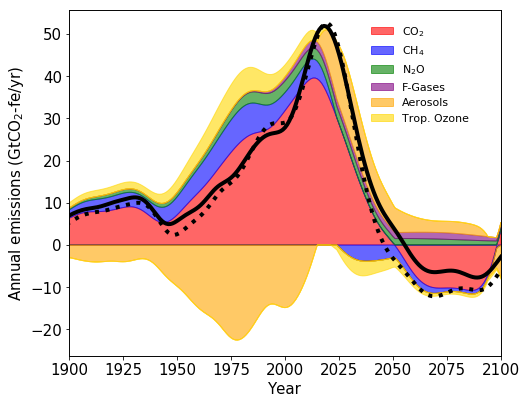

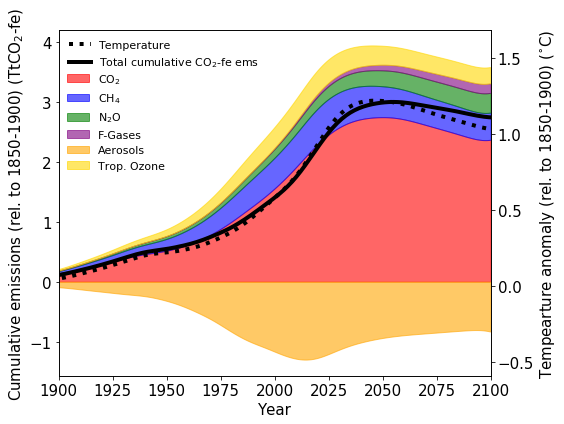

In [6]:
TCRE_value = 1.45*0.001*12/44

# fig_stack1, ax_stack1 = plt.subplots(figsize=(8,6))
fig_stack1 = plt.figure(figsize=(8,6))
ax_stack1 = fig_stack1.add_axes([0.12,0.1,0.75,0.8])
fig_stack2 = plt.figure(figsize=(8,6))
ax_stack2 = fig_stack2.add_axes([0.12,0.1,0.75,0.8])
# fig_stack2, ax_stack2 = plt.subplots(figsize=(8,6))
ax_stack1.set_xlim(1750,2100)
ax_stack2.set_xlim(1750,2100)

nyear_smoothing = 5

other_gwe_annual = gaussian_filter(fair_scm_emsback(other_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
tropOz_gwe_annual = gaussian_filter(fair_scm_emsback(tropOz_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
aerosol_gwe_annual = gaussian_filter(fair_scm_emsback(aerosol_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
n2o_gwe_annual = gaussian_filter(fair_scm_emsback(n2o_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
ch4_gwe_annual = gaussian_filter(fair_scm_emsback(ch4_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
fgases_gwe_annual = gaussian_filter(fair_scm_emsback(fgases_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
co2_gwe_annual = gaussian_filter(fair_scm_emsback(co2_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
# total_gwe_annual = gaussian_filter(fair_scm_emsback(total_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12

# plot annual timeseries
# ax_stack[0].fill_between(np.arange(1765,2101), np.zeros(2101-1765), other_gwe_annual, color='gold', alpha=0.6, edgecolor=None)

ax_stack1.fill_between(np.arange(1765,2101), np.zeros(2101-1765), co2_gwe_annual, color='red', alpha=0.6, edgecolor=None)

top_so_far = np.zeros(2101-1765)
bottom_so_far = np.zeros(2101-1765)
gas_to_add_positive = np.zeros(2101-1765)
gas_to_add_negative = np.zeros(2101-1765)

for val_pos in range(0,2101-1765):
    if co2_gwe_annual[val_pos] > 0:
        top_so_far[val_pos] += co2_gwe_annual[val_pos]
    else:
        bottom_so_far[val_pos] += co2_gwe_annual[val_pos]
    
    if ch4_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += ch4_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += ch4_gwe_annual[val_pos]

ax_stack1.fill_between(np.arange(1765,2101), top_so_far, top_so_far + gas_to_add_positive, color='blue', alpha=0.6, edgecolor=None)
ax_stack1.fill_between(np.arange(1765,2101), bottom_so_far, bottom_so_far + gas_to_add_negative, color='blue', alpha=0.6, edgecolor=None)


top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2101-1765)
gas_to_add_negative = np.zeros(2101-1765)

for val_pos in range(0,2101-1765):
    if n2o_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += n2o_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += n2o_gwe_annual[val_pos]

ax_stack1.fill_between(np.arange(1765,2101), top_so_far, top_so_far + gas_to_add_positive, color='green', alpha=0.6, edgecolor=None)
ax_stack1.fill_between(np.arange(1765,2101), bottom_so_far, bottom_so_far + gas_to_add_negative, color='green', alpha=0.6, edgecolor=None)


top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2101-1765)
gas_to_add_negative = np.zeros(2101-1765)

for val_pos in range(0,2101-1765):
    if fgases_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += fgases_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += fgases_gwe_annual[val_pos]

ax_stack1.fill_between(np.arange(1765,2101), top_so_far, top_so_far + gas_to_add_positive, color='purple', alpha=0.6, edgecolor=None)
ax_stack1.fill_between(np.arange(1765,2101), bottom_so_far, bottom_so_far + gas_to_add_negative, color='purple', alpha=0.6, edgecolor=None)


top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2101-1765)
gas_to_add_negative = np.zeros(2101-1765)

for val_pos in range(0,2101-1765):
    if aerosol_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += aerosol_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += aerosol_gwe_annual[val_pos]

ax_stack1.fill_between(np.arange(1765,2101), top_so_far, top_so_far + gas_to_add_positive, color='orange', alpha=0.6, edgecolor=None)
ax_stack1.fill_between(np.arange(1765,2101), bottom_so_far, bottom_so_far + gas_to_add_negative, color='orange', alpha=0.6, edgecolor=None)


top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2101-1765)
gas_to_add_negative = np.zeros(2101-1765)

for val_pos in range(0,2101-1765):
    if tropOz_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += tropOz_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += tropOz_gwe_annual[val_pos]

ax_stack1.fill_between(np.arange(1765,2101), top_so_far, top_so_far + gas_to_add_positive, color='gold', alpha=0.6, edgecolor=None)
ax_stack1.fill_between(np.arange(1765,2101), bottom_so_far, bottom_so_far + gas_to_add_negative, color='gold', alpha=0.6, edgecolor=None)


ax_stack1.plot(np.arange(1765,2101), top_so_far+bottom_so_far+gas_to_add_negative+gas_to_add_positive, color='black', linewidth=4)


T_total = gaussian_filter(fair_scm(other_rf=co2_rf_50_plushist+ch4_rf_50_plushist+n2o_rf_50_plushist+fgases_rf_50_plushist+aerosol_rf_50_plushist+tropOz_rf_50_plushist)[1], nyear_smoothing, mode='nearest')


# plot cumulative timeseries
co2_ems_50_co2gwe = np.cumsum(co2_gwe_annual)
ch4_ems_50_co2gwe = np.cumsum(ch4_gwe_annual)
n2o_ems_50_co2gwe = np.cumsum(n2o_gwe_annual)
fgases_ems_50_co2gwe = np.cumsum(fgases_gwe_annual)
aerosol_ems_50_co2gwe = np.cumsum(aerosol_gwe_annual)
tropOz_ems_50_co2gwe = np.cumsum(tropOz_gwe_annual)
other_ems_50_co2gwe = np.cumsum(other_gwe_annual)
total_ems_50_co2gwe = co2_ems_50_co2gwe + ch4_ems_50_co2gwe + n2o_ems_50_co2gwe + fgases_ems_50_co2gwe + aerosol_ems_50_co2gwe + tropOz_ems_50_co2gwe

ax_stack2.plot(np.arange(1765,2101), (total_ems_50_co2gwe - np.mean(total_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='black', linewidth=4)

ax_stack2.fill_between(np.arange(1765,2101), np.zeros(2101-1765), (co2_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='red', alpha=0.6)
# ax_stack[1].fill_between(np.arange(1765,2101), co2_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]), other_ems_50_co2gwe+co2_ems_50_co2gwe - np.mean(other_ems_50_co2gwe[1850-1765:1901-1765]+co2_ems_50_co2gwe[1850-1765:1901-1765]), color='gold', alpha=0.6)
ax_stack2.fill_between(np.arange(1765,2101), (co2_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]))/1000., (co2_ems_50_co2gwe+ch4_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='blue', alpha=0.6)
ax_stack2.fill_between(np.arange(1765,2101), (co2_ems_50_co2gwe+ch4_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]))/1000., (co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='green', alpha=0.6)
ax_stack2.fill_between(np.arange(1765,2101), (co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]))/1000., (co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]+fgases_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='purple', alpha=0.6)
ax_stack2.fill_between(np.arange(1765,2101), (co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]+fgases_ems_50_co2gwe[1850-1765:1901-1765]))/1000., (co2_ems_50_co2gwe+ch4_ems_50_co2gwe+n2o_ems_50_co2gwe+fgases_ems_50_co2gwe+tropOz_ems_50_co2gwe - np.mean(co2_ems_50_co2gwe[1850-1765:1901-1765]+ch4_ems_50_co2gwe[1850-1765:1901-1765]+n2o_ems_50_co2gwe[1850-1765:1901-1765]+fgases_ems_50_co2gwe[1850-1765:1901-1765]+tropOz_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='gold', alpha=0.6)
ax_stack2.fill_between(np.arange(1765,2101), np.zeros(2101-1765), (aerosol_ems_50_co2gwe - np.mean(aerosol_ems_50_co2gwe[1850-1765:1901-1765]))/1000., color='orange', alpha=0.6)

ax_temp = ax_stack2.twinx()
ax_temp.set_xlim(1900,2100)
ax_stack1.set_xlim(1900,2100)
ax_stack2.set_xlim(1900,2100)
ax_temp.set_ylim(-1.500*TCRE_value*1000,4.250*TCRE_value*1000)
# ax_temp.set_yticks([-0.5,0.0,0.5,1.0,1.5])

ax_temp.plot(np.arange(1765,2101), T_total-np.mean(T_total[1850-1765:1901-1765]), color='black', linewidth=4, linestyle=':')
ax_temp.plot(np.arange(1765,2101), TCRE*(total_ems_50_co2gwe - np.mean(total_ems_50_co2gwe[1850-1765:1901-1765])), color='black', linestyle=':', linewidth=4)

ax_temp_annual = ax_stack1.twinx()
ax_temp_annual.set_xlim(1900,2100)
ax_temp_annual.set_ylim(-27*TCRE_value,60*TCRE_value)
# ax_temp_annual.set_yticks([-0.5,0.0,0.5,1.0,1.5])
T_gradient = T_total - np.roll(T_total,1)
T_gradient[0] = 0.0
ax_temp_annual.plot(np.arange(1765,2101), T_gradient, color='black', linestyle=':', linewidth=4)

ax_stack1.axes.fontsize = 15

ax_stack1.set_xlabel('Year', fontsize=15)
ax_stack2.set_xlabel('Year', fontsize=15)
ax_temp.set_ylabel('Tempearture anomaly (rel. to 1850-1900) ($^{\circ}$C)', fontsize=15)
ax_stack1.set_ylabel('Annual emissions (GtCO$_2$-fe/yr)', fontsize=15)
ax_stack2.set_ylabel('Cumulative emissions (rel. to 1850-1900) (TtCO$_2$-fe)', fontsize=15)

ax_stack1.tick_params(axis='both', which='major', labelsize=15)
ax_stack2.tick_params(axis='both', which='major', labelsize=15)
ax_temp.tick_params(axis='y', which='major', labelsize=15)
ax_temp_annual.tick_params(axis='y', which='major', labelsize=15)
ax_temp_annual.set_yticks([])

legend_elements = [Line2D([0], [0], color='black', lw=4, linestyle=':', label='Temperature'),
                  Line2D([0], [0], color='black', lw=4, label='Total cumulative CO$_2$-fe ems')]

legend_elements2 = [Patch(facecolor='red', edgecolor='red',label='CO$_2$', alpha=0.6),
                   Patch(facecolor='blue', edgecolor='blue',label='CH$_4$', alpha=0.6),
                   Patch(facecolor='green', edgecolor='green',label='N$_2$O', alpha=0.6),
                   Patch(facecolor='purple', edgecolor='purple',label='F-Gases', alpha=0.6),
                   Patch(facecolor='orange', edgecolor='orange',label='Aerosols', alpha=0.6),
                   Patch(facecolor='gold', edgecolor='gold',label='Trop. Ozone', alpha=0.6)]

ax_stack2.legend(handles=legend_elements, loc='upper left', edgecolor='white', framealpha=0.0, fontsize=11)
ax_stack1.legend(handles=legend_elements2, loc=(0.69,0.66), edgecolor='white', framealpha=0.0, fontsize=11)
ax_temp.legend(handles=legend_elements2, loc=(0.01,0.58), edgecolor='white', framealpha=0.0, fontsize=11)

plt.show()

# fig_stack1.savefig('Figure2_1.pdf', dpi=300)
# fig_stack2.savefig('Figure2_2.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


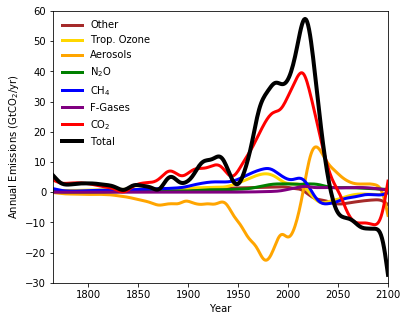

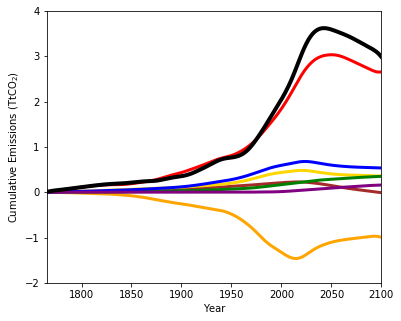

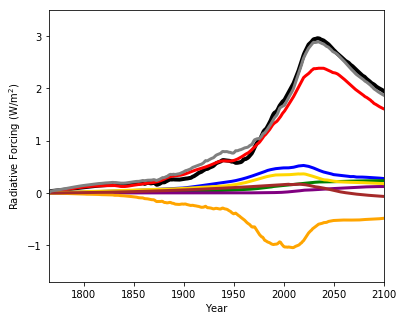

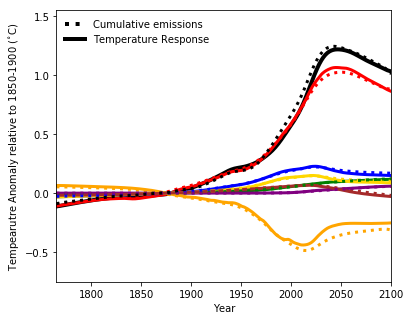

In [6]:
plt.figure(figsize=(6,5))

plt.plot(np.arange(1765,2101), other_gwe_annual, color='brown', linewidth=3, label='Other')
plt.plot(np.arange(1765,2101), tropOz_gwe_annual, color='gold', linewidth=3, label='Trop. Ozone')
plt.plot(np.arange(1765,2101), aerosol_gwe_annual, color='orange', linewidth=3, label='Aerosols') 
plt.plot(np.arange(1765,2101), n2o_gwe_annual, color='green', linewidth=3, label='N$_2$O')
plt.plot(np.arange(1765,2101), ch4_gwe_annual, color='blue', linewidth=3, label='CH$_4$')
plt.plot(np.arange(1765,2101), fgases_gwe_annual, color='purple', linewidth=3, label='F-Gases')
plt.plot(np.arange(1765,2101), co2_gwe_annual, color='red', linewidth=3, label='CO$_2$')
plt.plot(np.arange(1765,2101), total_gwe_annual, color='black', linewidth=4, label='Total')

plt.xlim(1765,2100)
plt.ylim(-30,60)
plt.xlabel('Year')
plt.ylabel('Annual Emissions (GtCO$_2$/yr)')

plt.legend(loc='best', framealpha=1, edgecolor='white')

# plt.savefig('annual_co2fe.pdf', dpi=300)


plt.figure(figsize=(6,5))

plt.plot(np.arange(1765,2101), 0.001*np.cumsum(other_gwe_annual), color='brown', linewidth=3)
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(tropOz_gwe_annual), color='gold', linewidth=3)
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(aerosol_gwe_annual), color='orange', linewidth=3) 
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(n2o_gwe_annual), color='green', linewidth=3)
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(ch4_gwe_annual), color='blue', linewidth=3)
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(fgases_gwe_annual), color='purple', linewidth=3)
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(co2_gwe_annual), color='red', linewidth=3)
plt.plot(np.arange(1765,2101), 0.001*np.cumsum(total_gwe_annual), color='black', linewidth=4)

plt.xlim(1765,2100)
plt.ylim(-2,4)
plt.xlabel('Year')
plt.ylabel('Cumulative Emissions (TtCO$_2$)')

# plt.savefig('cumulative_co2fe.pdf', dpi=300)


plt.figure(figsize=(6,5))

plt.plot(np.arange(1765,2101), total_rf_50_plushist, color='black', linewidth=4)
plt.plot(np.arange(1765,2101), co2_rf_50_plushist, color='red', linewidth=3)
plt.plot(np.arange(1765,2101), ch4_rf_50_plushist, color='blue', linewidth=3)
plt.plot(np.arange(1765,2101), n2o_rf_50_plushist, color='green', linewidth=3)
plt.plot(np.arange(1765,2101), fgases_rf_50_plushist, color='purple', linewidth=3)
plt.plot(np.arange(1765,2101), aerosol_rf_50_plushist, color='orange', linewidth=3)
plt.plot(np.arange(1765,2101), tropOz_rf_50_plushist, color='gold', linewidth=3)
plt.plot(np.arange(1765,2101), other_rf_50_plushist, color='brown', linewidth=3)

plt.plot(np.arange(1765,2101), co2_rf_50_plushist+ch4_rf_50_plushist+n2o_rf_50_plushist+fgases_rf_50_plushist+aerosol_rf_50_plushist+tropOz_rf_50_plushist+other_rf_50_plushist, color='grey', linewidth=3)  

plt.xlim(1765,2100)
plt.ylim(-1.7,3.5)
plt.xlabel('Year')
plt.ylabel('Radiative Forcing (W/m$^2$)')

# plt.savefig('radiative_forcings.pdf', dpi=300)


plt.figure(figsize=(6,5))

plt.plot(np.arange(1765,2101), T_total - np.mean(T_total[1850-1765:1901-1765]), color='black', linewidth=4)
plt.plot(np.arange(1765,2101), T_co2 - np.mean(T_co2[1850-1765:1901-1765]), color='red', linewidth=3)
plt.plot(np.arange(1765,2101), T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]), color='blue', linewidth=3)
plt.plot(np.arange(1765,2101), T_n2o - np.mean(T_n2o[1850-1765:1901-1765]), color='green', linewidth=3)
plt.plot(np.arange(1765,2101), T_fgases - np.mean(T_fgases[1850-1765:1901-1765]), color='purple', linewidth=3)
plt.plot(np.arange(1765,2101), T_aerosol - np.mean(T_aerosol[1850-1765:1901-1765]), color='orange', linewidth=3)
plt.plot(np.arange(1765,2101), T_tropOz - np.mean(T_tropOz[1850-1765:1901-1765]), color='gold', linewidth=3)
plt.plot(np.arange(1765,2101), T_other - np.mean(T_other[1850-1765:1901-1765]), color='brown', linewidth=3)

T_sum = T_co2+T_ch4+T_n2o+T_fgases+T_aerosol+T_tropOz+T_other
# plt.plot(np.arange(1765,2101), T_sum - np.mean(T_sum[1850-1765:1901-1765]), color='grey', linewidth=3)


plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(other_gwe_annual)-np.sum(other_gwe_annual[:1871-1765])), color='brown', linestyle=':', linewidth=3)
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(tropOz_gwe_annual)-np.sum(tropOz_gwe_annual[:1871-1765])), color='gold', linestyle=':', linewidth=3)
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(aerosol_gwe_annual)-np.sum(aerosol_gwe_annual[:1871-1765])), color='orange', linestyle=':', linewidth=3) 
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])), color='green', linestyle=':', linewidth=3)
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])), color='blue', linestyle=':', linewidth=3)
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])), color='purple', linestyle=':', linewidth=3)
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])), color='red', linestyle=':', linewidth=3)
plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(total_gwe_annual)-np.sum(total_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=3)

plt.xlim(1765,2100)
plt.ylim(-0.75,1.55)
plt.xlabel('Year')
plt.ylabel('Tempearutre Anomaly relative to 1850-1900 ($^{\circ}$C)')

legend_elements = [Line2D([0], [0], color='black', lw=4, linestyle=':', label='Cumulative emissions'),
                   Line2D([0], [0], color='black', lw=4, label='Temperature Response')]

plt.legend(handles=legend_elements, loc='best', framealpha=1, edgecolor='white')

# plt.savefig('temps.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


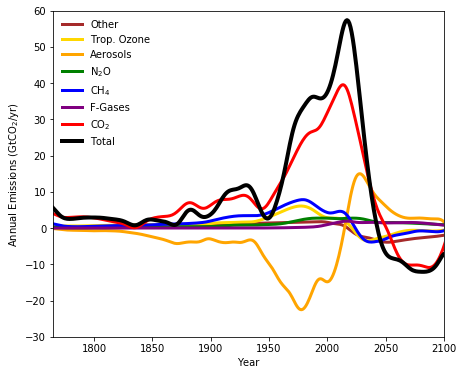

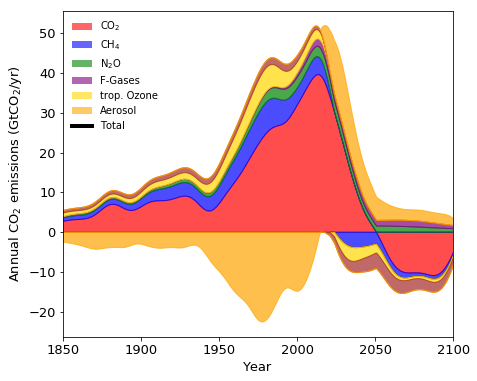

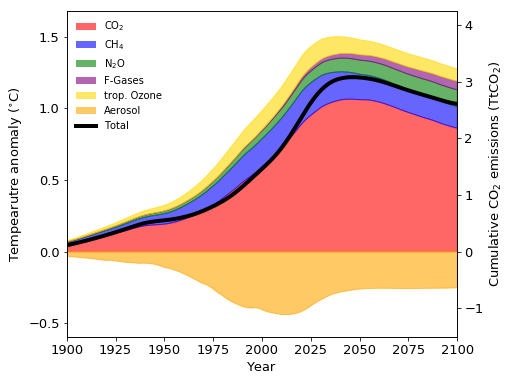

In [22]:
# other_gwe_annual = gaussian_filter(fair_scm_emsback(other_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
# tropOz_gwe_annual = gaussian_filter(fair_scm_emsback(tropOz_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
# aerosol_gwe_annual = gaussian_filter(fair_scm_emsback(aerosol_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
# n2o_gwe_annual = gaussian_filter(fair_scm_emsback(n2o_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
# ch4_gwe_annual = gaussian_filter(fair_scm_emsback(ch4_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12
# fgases_gwe_annual = gaussian_filter(fair_scm_emsback(fgases_rf_50_plushist)[1], nyear_smoothing, mode='nearest')*44/12

alpha_val = 0.7
nyear_smoothing = 5

co2_rf_50_hist_fut = np.append(co2_rf_50_plushist, np.ones(10)*co2_rf_50_plushist[-1])
ch4_rf_50_hist_fut = np.append(ch4_rf_50_plushist, np.ones(10)*ch4_rf_50_plushist[-1])
n2o_rf_50_hist_fut = np.append(n2o_rf_50_plushist, np.ones(10)*n2o_rf_50_plushist[-1])
fgases_rf_50_hist_fut = np.append(fgases_rf_50_plushist, np.ones(10)*fgases_rf_50_plushist[-1])
aerosol_rf_50_hist_fut = np.append(aerosol_rf_50_plushist, np.ones(10)*aerosol_rf_50_plushist[-1])
tropOz_rf_50_hist_fut = np.append(tropOz_rf_50_plushist, np.ones(10)*tropOz_rf_50_plushist[-1])
other_rf_50_hist_fut = np.append(other_rf_50_plushist, np.ones(10)*other_rf_50_plushist[-1])
total_rf_50_hist_fut = np.append(total_rf_50_plushist, np.ones(10)*total_rf_50_plushist[-1])

co2_gwe_annual = gaussian_filter(fair_scm_emsback(co2_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
other_gwe_annual = gaussian_filter(fair_scm_emsback(other_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
tropOz_gwe_annual = gaussian_filter(fair_scm_emsback(tropOz_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
aerosol_gwe_annual = gaussian_filter(fair_scm_emsback(aerosol_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
n2o_gwe_annual = gaussian_filter(fair_scm_emsback(n2o_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
ch4_gwe_annual = gaussian_filter(fair_scm_emsback(ch4_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
fgases_gwe_annual = gaussian_filter(fair_scm_emsback(fgases_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12
total_gwe_annual = gaussian_filter(fair_scm_emsback(total_rf_50_hist_fut)[1], nyear_smoothing, mode='nearest')*44/12

sum_T = fair_scm(other_rf=co2_rf_50_hist_fut+ch4_rf_50_hist_fut+n2o_rf_50_hist_fut+fgases_rf_50_hist_fut+aerosol_rf_50_hist_fut+tropOz_rf_50_hist_fut)[1]

plt.figure(figsize=(7,6))

plt.plot(np.arange(1765,2111), other_gwe_annual, color='brown', linewidth=3, label='Other')
plt.plot(np.arange(1765,2111), tropOz_gwe_annual, color='gold', linewidth=3, label='Trop. Ozone')
plt.plot(np.arange(1765,2111), aerosol_gwe_annual, color='orange', linewidth=3, label='Aerosols') 
plt.plot(np.arange(1765,2111), n2o_gwe_annual, color='green', linewidth=3, label='N$_2$O')
plt.plot(np.arange(1765,2111), ch4_gwe_annual, color='blue', linewidth=3, label='CH$_4$')
plt.plot(np.arange(1765,2111), fgases_gwe_annual, color='purple', linewidth=3, label='F-Gases')
plt.plot(np.arange(1765,2111), co2_gwe_annual, color='red', linewidth=3, label='CO$_2$')
plt.plot(np.arange(1765,2111), total_gwe_annual, color='black', linewidth=4, label='Total')

plt.xlim(1765,2100)
plt.ylim(-30,60)
plt.xlabel('Year')
plt.ylabel('Annual Emissions (GtCO$_2$/yr)')

plt.legend(loc='best', framealpha=1, edgecolor='white')

# plt.savefig('annual_co2fe.pdf', dpi=300)

fig_annual, ax_annual = plt.subplots(figsize=(7,6))
ax_annual.set_xlabel('Year', fontsize=13)
ax_annual.set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)', fontsize=13)
ax_annual.set_xlim(1850,2100)
ax_annual.tick_params(labelsize = 13)

years_array = np.arange(1765,2111)

ax_annual.fill_between(np.arange(1765,2111), co2_gwe_annual, color='red', alpha=alpha_val, edgecolor=None)

top_so_far = np.zeros(2111-1765)
bottom_so_far = np.zeros(2111-1765)
gas_to_add_positive = np.zeros(2111-1765)
gas_to_add_negative = np.zeros(2111-1765)

for val_pos in range(0,2111-1765):
    if co2_gwe_annual[val_pos] > 0:
        top_so_far[val_pos] += co2_gwe_annual[val_pos]
    else:
        bottom_so_far[val_pos] += co2_gwe_annual[val_pos]
    
    if ch4_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += ch4_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += ch4_gwe_annual[val_pos]

ax_annual.fill_between(np.arange(1765,2111), top_so_far, top_so_far + gas_to_add_positive, color='blue', alpha=alpha_val, edgecolor=None)
ax_annual.fill_between(np.arange(1765,2111), bottom_so_far, bottom_so_far + gas_to_add_negative, color='blue', alpha=alpha_val, edgecolor=None)

top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2111-1765)
gas_to_add_negative = np.zeros(2111-1765)

for val_pos in range(0,2111-1765):    
    if n2o_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += n2o_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += n2o_gwe_annual[val_pos]

ax_annual.fill_between(np.arange(1765,2111), top_so_far, top_so_far + gas_to_add_positive, color='green', alpha=alpha_val, edgecolor=None)
ax_annual.fill_between(np.arange(1765,2111), bottom_so_far, bottom_so_far + gas_to_add_negative, color='green', alpha=alpha_val, edgecolor=None)

top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2111-1765)
gas_to_add_negative = np.zeros(2111-1765)

for val_pos in range(0,2111-1765):
    if fgases_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += fgases_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += fgases_gwe_annual[val_pos]

ax_annual.fill_between(np.arange(1765,2111), top_so_far, top_so_far + gas_to_add_positive, color='purple', alpha=alpha_val, edgecolor=None)
ax_annual.fill_between(np.arange(1765,2111), bottom_so_far, bottom_so_far + gas_to_add_negative, color='purple', alpha=alpha_val, edgecolor=None)

top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2111-1765)
gas_to_add_negative = np.zeros(2111-1765)

for val_pos in range(0,2111-1765):
    if tropOz_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += tropOz_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += tropOz_gwe_annual[val_pos]

ax_annual.fill_between(np.arange(1765,2111), top_so_far, top_so_far + gas_to_add_positive, color='gold', alpha=alpha_val, edgecolor=None)
ax_annual.fill_between(np.arange(1765,2111), bottom_so_far, bottom_so_far + gas_to_add_negative, color='gold', alpha=alpha_val, edgecolor=None)

top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2111-1765)
gas_to_add_negative = np.zeros(2111-1765)

for val_pos in range(0,2111-1765):
    if other_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += other_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += other_gwe_annual[val_pos]

ax_annual.fill_between(np.arange(1765,2111), top_so_far, top_so_far + gas_to_add_positive, color='brown', alpha=alpha_val, edgecolor=None)
ax_annual.fill_between(np.arange(1765,2111), bottom_so_far, bottom_so_far + gas_to_add_negative, color='brown', alpha=alpha_val, edgecolor=None)

top_so_far += gas_to_add_positive
bottom_so_far += gas_to_add_negative
gas_to_add_positive = np.zeros(2111-1765)
gas_to_add_negative = np.zeros(2111-1765)

for val_pos in range(0,2111-1765):
    if aerosol_gwe_annual[val_pos] > 0:
        gas_to_add_positive[val_pos] += aerosol_gwe_annual[val_pos]
    else:
        gas_to_add_negative[val_pos] += aerosol_gwe_annual[val_pos]

ax_annual.fill_between(np.arange(1765,2111), top_so_far, top_so_far + gas_to_add_positive, color='orange', alpha=alpha_val, edgecolor=None)
ax_annual.fill_between(np.arange(1765,2111), bottom_so_far, bottom_so_far + gas_to_add_negative, color='orange', alpha=alpha_val, edgecolor=None)






fig1 = plt.figure(figsize=(7,6))
ax1 = fig1.add_subplot(111)

alpha_val = 0.6

# plt.plot(np.arange(1765,2101), T_total - np.mean(T_total[1850-1765:1901-1765]), color='black', linewidth=4)
plt.fill_between(np.arange(1765,2101), np.zeros_like(np.arange(1765,2101)), T_co2 - np.mean(T_co2[1850-1765:1901-1765]), color='red', alpha=alpha_val)
plt.fill_between(np.arange(1765,2101), T_co2 - np.mean(T_co2[1850-1765:1901-1765]), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]), color='blue', alpha=alpha_val)
plt.fill_between(np.arange(1765,2101), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]), color='green', alpha=alpha_val)
plt.fill_between(np.arange(1765,2101), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]) + T_fgases - np.mean(T_fgases[1850-1765:1901-1765]), color='purple', alpha=alpha_val)
plt.fill_between(np.arange(1765,2101), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]) + T_fgases - np.mean(T_fgases[1850-1765:1901-1765]), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]) + T_fgases - np.mean(T_fgases[1850-1765:1901-1765]) + T_tropOz - np.mean(T_tropOz[1850-1765:1901-1765]), color='gold', alpha=alpha_val)
# plt.fill_between(np.arange(1765,2101), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]) + T_fgases - np.mean(T_fgases[1850-1765:1901-1765]) + T_tropOz - np.mean(T_tropOz[1850-1765:1901-1765]), T_co2 - np.mean(T_co2[1850-1765:1901-1765]) + T_ch4 - np.mean(T_ch4[1850-1765:1901-1765]) + T_n2o - np.mean(T_n2o[1850-1765:1901-1765]) + T_fgases - np.mean(T_fgases[1850-1765:1901-1765]) + T_tropOz - np.mean(T_tropOz[1850-1765:1901-1765]) + T_other - np.mean(T_other[1850-1765:1901-1765]), color='brown', alpha=alpha_val)
plt.fill_between(np.arange(1765,2101), np.zeros_like(np.arange(1765,2101)), T_aerosol - np.mean(T_aerosol[1850-1765:1901-1765]), color='orange', alpha=alpha_val)

# T_sum = T_co2+T_ch4+T_n2o+T_fgases+T_aerosol+T_tropOz
T_sum = gaussian_filter(fair_scm(other_rf=co2_rf_50_plushist+ch4_rf_50_plushist+n2o_rf_50_plushist+fgases_rf_50_plushist+aerosol_rf_50_plushist+tropOz_rf_50_plushist)[1], nyear_smoothing, mode='nearest')
plt.plot(np.arange(1765,2101), T_sum - np.mean(T_sum[1850-1765:1901-1765]), color='black', linewidth=4)


# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])+np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])+np.cumsum(tropOz_gwe_annual)-np.sum(tropOz_gwe_annual[:1871-1765])+np.cumsum(other_gwe_annual)-np.sum(other_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])+np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])+np.cumsum(tropOz_gwe_annual)-np.sum(tropOz_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(aerosol_gwe_annual)-np.sum(aerosol_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val) 
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])+np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# plt.plot(np.arange(1765,2101), 1.35*(12/44)*0.001*(np.cumsum(total_gwe_annual)-np.sum(total_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=3)

plt.fill_betweenx([-1,6],[1850,1850],[1900,1900], color='black', alpha=0.1, zorder=0)

plt.xlim(1850,2100)
plt.ylim(-0.74,1.85)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Tempearutre anomaly ($^{\circ}$C)', fontsize=13)

ax2 = plt.twinx()

co2_gwe_annual = co2_gwe_annual[:-10]
ch4_gwe_annual = ch4_gwe_annual[:-10]
n2o_gwe_annual = n2o_gwe_annual[:-10]
fgases_gwe_annual = fgases_gwe_annual[:-10]
aerosol_gwe_annual = aerosol_gwe_annual[:-10]
tropOz_gwe_annual = tropOz_gwe_annual[:-10]
other_gwe_annual = other_gwe_annual[:-10]
total_gwe_annual = total_gwe_annual[:-10]

# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])+np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])+np.cumsum(tropOz_gwe_annual)-np.sum(tropOz_gwe_annual[:1871-1765])+np.cumsum(other_gwe_annual)-np.sum(other_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])+np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])+np.cumsum(tropOz_gwe_annual)-np.sum(tropOz_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(aerosol_gwe_annual)-np.sum(aerosol_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val) 
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])+np.cumsum(ch4_gwe_annual)-np.sum(ch4_gwe_annual[:1871-1765])+np.cumsum(n2o_gwe_annual)-np.sum(n2o_gwe_annual[:1871-1765])+np.cumsum(fgases_gwe_annual)-np.sum(fgases_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(co2_gwe_annual)-np.sum(co2_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=2, alpha=alpha_val)
# ax2.plot(np.arange(1765,2101), 0.001*(np.cumsum(total_gwe_annual)-np.sum(total_gwe_annual[:1871-1765])), color='black', linestyle=':', linewidth=3)

ax2.set_ylim(-0.739*(44/12)*(1/1.35),1.845*(44/12)*(1/1.35))
ax2.set_ylabel('Cumulative CO$_2$ emissions (TtCO$_2$)', fontsize=13)

ax2.tick_params(labelsize=13)
ax1.tick_params(labelsize=13)

legend_elements = [Line2D([0], [0], color='black', lw=4, linestyle=':', label='Cumulative emissions'),
                   Line2D([0], [0], color='black', lw=4, label='Temperature Response')]

plt.legend(handles=legend_elements, loc='upper left', framealpha=0, edgecolor='none')


from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements2 = [Patch(facecolor='red', edgecolor='none', alpha=alpha_val, label='CO$_2$'),
                  Patch(facecolor='blue', edgecolor='none', alpha=alpha_val, label='CH$_4$'),
                  Patch(facecolor='green', edgecolor='none', alpha=alpha_val, label='N$_2$O'),
                  Patch(facecolor='purple', edgecolor='none', alpha=alpha_val, label='F-Gases'),
                  Patch(facecolor='gold', edgecolor='none', alpha=alpha_val, label='trop. Ozone'),
                  Patch(facecolor='orange', edgecolor='none', alpha=alpha_val, label='Aerosol'),
                  Line2D([0],[0],color='black',lw=4,label='Total')]

ax_annual.legend(handles=legend_elements2, loc='upper left', framealpha=0, edgecolor='none')
ax2.legend(handles=legend_elements2, loc='upper left', framealpha=0, edgecolor='none')

ax1.set_xlim(1900,2100)
ax2.set_ylim(-1.500,4.250)

ax1.set_ylim(-1.500*TCRE_value*1000,4.250*TCRE_value*1000)

# fig_annual.savefig('figure2_1.pdf', dpi=300)
# fig1.savefig('figure2_2_temp.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


Text(1780, 0.43, 'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\\circ}$C/TtC')

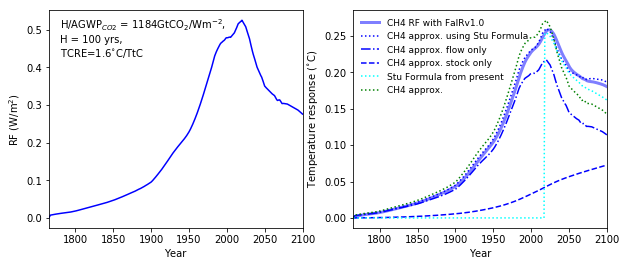

In [9]:
fig_mytechnique, ax_mytechnique = plt.subplots(1,2,figsize=(10,4))
ax_mytechnique[0].set_xlabel('Year')
ax_mytechnique[0].set_ylabel('RF (W/m$^2$)')
ax_mytechnique[1].set_xlabel('Year')
ax_mytechnique[1].set_ylabel('Temperature response ($^{\circ}$C)')


ax_mytechnique[0].plot(np.arange(1765,2101), ch4_rf_50_plushist, color='blue')

H = 100
TCRE = 1.6 # 1.45
AGWP_CO2 = H/1184. # 950
alpha = 0.2

# what we are aiming for
T_ch4_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-ch4_rf_50_plushist)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_ch4_50, color='blue', linewidth=3, alpha=0.5, label='CH4 RF with FaIRv1.0')

# using my technique
ch4_temperature_approx = np.zeros(2101-1765)
for i in range(1,2101-1765):
    ch4_temperature_approx[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])) + (alpha*np.mean(ch4_rf_50_plushist[:i+1])*i))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx, color='blue', linestyle=':', label='CH4 approx. using Stu Formula')

# decomposing into the flow component
ch4_temperature_approx_5 = np.zeros(2101-1765)
for i in range(1,2101-1765):
    ch4_temperature_approx_5[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_5, color='blue', linestyle='-.', label='CH4 approx. flow only')

# and the stock component
ch4_temperature_approx_6 = np.zeros(2101-1765)
for i in range(1,2101-1765):
    ch4_temperature_approx_6[i] = TCRE*0.001*(12/44)*(alpha*np.mean(ch4_rf_50_plushist[:i+1])*i)/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_6, color='blue', linestyle='--', label='CH4 approx. stock only')



AGWP_CO2 = H/850.
TCRE = 1.3

ch4_temperature_approx_frompresent = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    ch4_temperature_approx_frompresent[i] = T_ch4_50[2018-1765] + TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i]-ch4_rf_50_plushist[2018-1765])) + (alpha*np.mean(ch4_rf_50_plushist[2018-1765:i+1]-ch4_rf_50_plushist[2018-1765])*i))/AGWP_CO2  

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent, color='cyan', linestyle=':', label='Stu Formula from present')


AGWP_CO2 = H/1184.
TCRE = 1.6
alpha=0.0

# using my technique
ch4_temperature_approx_test = np.zeros(2101-1765)
for i in range(1,2101-1765):
    ch4_temperature_approx_test[i] = ch4_temperature_approx_test[i-1] + TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-1])))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_test, color='green', linestyle=':', label='CH4 approx.')



ax_mytechnique[1].legend(loc='upper left', edgecolor='white', framealpha=0, fontsize=9)
ax_mytechnique[0].set_xlim(1765,2100) 
ax_mytechnique[1].set_xlim(1765,2100)
ax_mytechnique[0].text(1780,0.43,'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\circ}$C/TtC')

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


Text(1780, 0.43, 'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\\circ}$C/TtC')

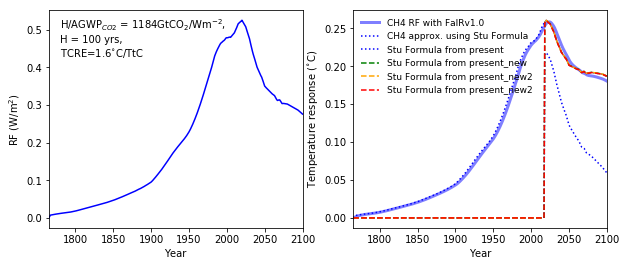

In [10]:
fig_mytechnique, ax_mytechnique = plt.subplots(1,2,figsize=(10,4))
ax_mytechnique[0].set_xlabel('Year')
ax_mytechnique[0].set_ylabel('RF (W/m$^2$)')
ax_mytechnique[1].set_xlabel('Year')
ax_mytechnique[1].set_ylabel('Temperature response ($^{\circ}$C)')


ax_mytechnique[0].plot(np.arange(1765,2101), ch4_rf_50_plushist, color='blue')

H = 100
TCRE = 1.6 # 1.45
AGWP_CO2 = H/1184. # 950
alpha = 0.2

# what we are aiming for
T_ch4_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-ch4_rf_50_plushist)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_ch4_50, color='blue', linewidth=3, alpha=0.5, label='CH4 RF with FaIRv1.0')

# using my technique
ch4_temperature_approx = np.zeros(2101-1765)
for i in range(1,2101-1765):
    ch4_temperature_approx[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])) + (alpha*np.mean(ch4_rf_50_plushist[:i+1])*i))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx, color='blue', linestyle=':', label='CH4 approx. using Stu Formula')

# # decomposing into the flow component
# ch4_temperature_approx_5 = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_5[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_5, color='blue', linestyle='-.', label='CH4 approx. flow only')

# # and the stock component
# ch4_temperature_approx_6 = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_6[i] = TCRE*0.001*(12/44)*(alpha*np.mean(ch4_rf_50_plushist[:i+1])*i)/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_6, color='blue', linestyle='--', label='CH4 approx. stock only')



ch4_temperature_approx_frompresent = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    ch4_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i])) + (alpha*np.mean(ch4_rf_50_plushist[2018-1765:i+1]-ch4_rf_50_plushist[2018-1765])*i) + (alpha*np.mean(ch4_rf_50_plushist[:2018-1765])))/AGWP_CO2  

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent, color='blue', linestyle=':', label='Stu Formula from present')



ch4_temperature_approx_frompresent_new = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    ch4_temperature_approx_frompresent_new[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] + alpha*np.sum(ch4_rf_50_plushist[:i+1])/(H*(1-alpha)))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new, color='green', linestyle='--', label='Stu Formula from present_ne w')


ch4_temperature_approx_frompresent_new2 = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
    ch4_temperature_approx_frompresent_new2[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[2018-1765] + alpha*np.mean(ch4_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new2, color='orange', linestyle='--', label='Stu Formula from present_new2')



ch4_temperature_approx_frompresent_20yr = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i-20] + alpha*np.sum(ch4_rf_50_plushist[:i-20])/(H*(1-alpha)))/AGWP_CO2
    
    ch4_temperature_approx_frompresent_20yr[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-20] + alpha*np.mean(ch4_rf_50_plushist[i-20:i+1])*(20)/(H*(1-alpha)))/AGWP_CO2 + offsets

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_20yr, color='red', linestyle='--', label='Stu Formula from present_new2')





# AGWP_CO2 = H/1184.
# TCRE = 1.6
# alpha=0.0

# # using my technique
# ch4_temperature_approx_test = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_test[i] = ch4_temperature_approx_test[i-1] + TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-1])))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_test, color='green', linestyle=':', label='CH4 approx.')



ax_mytechnique[1].legend(loc='upper left', edgecolor='white', framealpha=0, fontsize=9)
ax_mytechnique[0].set_xlim(1765,2100) 
ax_mytechnique[1].set_xlim(1765,2100)
ax_mytechnique[0].text(1780,0.43,'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\circ}$C/TtC')

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


Text(1780, 0.43, 'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\\circ}$C/TtC')

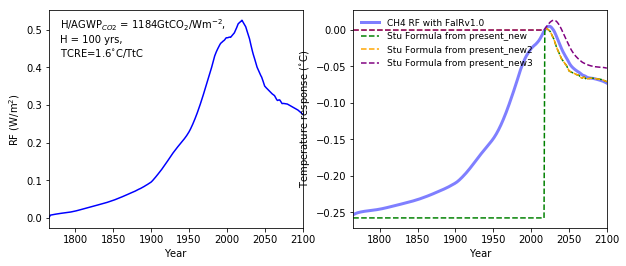

In [11]:
fig_mytechnique, ax_mytechnique = plt.subplots(1,2,figsize=(10,4))
ax_mytechnique[0].set_xlabel('Year')
ax_mytechnique[0].set_ylabel('RF (W/m$^2$)')
ax_mytechnique[1].set_xlabel('Year')
ax_mytechnique[1].set_ylabel('Temperature response ($^{\circ}$C)')


ax_mytechnique[0].plot(np.arange(1765,2101), ch4_rf_50_plushist, color='blue')

H = 100
TCRE = 1.6 # 1.45
AGWP_CO2 = H/1184. # 950
alpha = 0.2

# what we are aiming for
T_ch4_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-ch4_rf_50_plushist)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_ch4_50-T_ch4_50[2018-1765], color='blue', linewidth=3, alpha=0.5, label='CH4 RF with FaIRv1.0')

# # using my technique
# ch4_temperature_approx = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])) + (alpha*np.mean(ch4_rf_50_plushist[:i+1])*i))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx, color='blue', linestyle=':', label='CH4 approx. using Stu Formula')

# # decomposing into the flow component
# ch4_temperature_approx_5 = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_5[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_5, color='blue', linestyle='-.', label='CH4 approx. flow only')

# # and the stock component
# ch4_temperature_approx_6 = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_6[i] = TCRE*0.001*(12/44)*(alpha*np.mean(ch4_rf_50_plushist[:i+1])*i)/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_6, color='blue', linestyle='--', label='CH4 approx. stock only')



# ch4_temperature_approx_frompresent = np.zeros(2101-1765)
# for i in range(2018-1765,2101-1765):
#     ch4_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i])) + (alpha*np.mean(ch4_rf_50_plushist[2018-1765:i+1]-ch4_rf_50_plushist[2018-1765])*i) + (alpha*np.mean(ch4_rf_50_plushist[:2018-1765])))/AGWP_CO2  

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent, color='blue', linestyle=':', label='Stu Formula from present')



ch4_temperature_approx_frompresent_new = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    ch4_temperature_approx_frompresent_new[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] + alpha*np.sum(ch4_rf_50_plushist[:i+1])/(H*(1-alpha)))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new - ch4_temperature_approx_frompresent_new[2018-1765], color='green', linestyle='--', label='Stu Formula from present_new')


ch4_temperature_approx_frompresent_new2 = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
    ch4_temperature_approx_frompresent_new2[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[2018-1765] + alpha*np.mean(ch4_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new2, color='orange', linestyle='--', label='Stu Formula from present_new2')



ch4_temperature_approx_frompresent_new3 = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
    ch4_temperature_approx_frompresent_new3[i] = ch4_temperature_approx_frompresent_new3[i-1] + TCRE*0.001*(12/44)*H*(1-alpha)*((ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-20])/20 + alpha*ch4_rf_50_plushist[i]/(H*(1-alpha)))/AGWP_CO2 + offsets

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new3, color='purple', linestyle='--', label='Stu Formula from present_new3')





# AGWP_CO2 = H/1184.
# TCRE = 1.6
# alpha=0.0

# # using my technique
# ch4_temperature_approx_test = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_test[i] = ch4_temperature_approx_test[i-1] + TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-1])))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_test, color='green', linestyle=':', label='CH4 approx.')




ax_mytechnique[1].legend(loc='upper left', edgecolor='white', framealpha=0, fontsize=9)
ax_mytechnique[0].set_xlim(1765,2100) 
ax_mytechnique[1].set_xlim(1765,2100)
ax_mytechnique[0].text(1780,0.43,'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\circ}$C/TtC')

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


Text(1780, 0.43, 'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\\circ}$C/TtC')

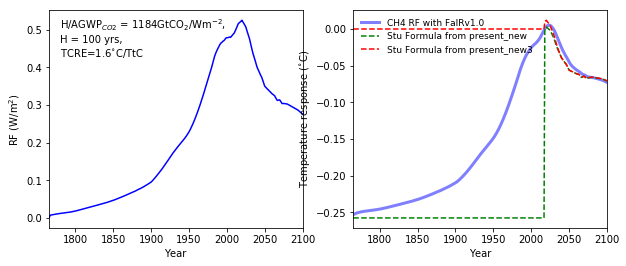

In [12]:
# For all gases

fig_mytechnique, ax_mytechnique = plt.subplots(1,2,figsize=(10,4))
ax_mytechnique[0].set_xlabel('Year')
ax_mytechnique[0].set_ylabel('RF (W/m$^2$)')
ax_mytechnique[1].set_xlabel('Year')
ax_mytechnique[1].set_ylabel('Temperature response ($^{\circ}$C)')


ax_mytechnique[0].plot(np.arange(1765,2101), ch4_rf_50_plushist, color='blue')

H = 100
TCRE = 1.6 # 1.45
AGWP_CO2 = H/1184. # 950
alpha = 0.2

# what we are aiming for
T_ch4_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-ch4_rf_50_plushist)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_ch4_50-T_ch4_50[2018-1765], color='blue', linewidth=3, alpha=0.5, label='CH4 RF with FaIRv1.0')

# # using my technique
# ch4_temperature_approx = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])) + (alpha*np.mean(ch4_rf_50_plushist[:i+1])*i))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx, color='blue', linestyle=':', label='CH4 approx. using Stu Formula')

# # decomposing into the flow component
# ch4_temperature_approx_5 = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_5[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[0])))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_5, color='blue', linestyle='-.', label='CH4 approx. flow only')

# # and the stock component
# ch4_temperature_approx_6 = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_6[i] = TCRE*0.001*(12/44)*(alpha*np.mean(ch4_rf_50_plushist[:i+1])*i)/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_6, color='blue', linestyle='--', label='CH4 approx. stock only')



# ch4_temperature_approx_frompresent = np.zeros(2101-1765)
# for i in range(2018-1765,2101-1765):
#     ch4_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i])) + (alpha*np.mean(ch4_rf_50_plushist[2018-1765:i+1]-ch4_rf_50_plushist[2018-1765])*i) + (alpha*np.mean(ch4_rf_50_plushist[:2018-1765])))/AGWP_CO2  

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent, color='blue', linestyle=':', label='Stu Formula from present')



ch4_temperature_approx_frompresent_new = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    ch4_temperature_approx_frompresent_new[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] + alpha*np.sum(ch4_rf_50_plushist[:i+1])/(H*(1-alpha)))/AGWP_CO2

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new - ch4_temperature_approx_frompresent_new[2018-1765], color='green', linestyle='--', label='Stu Formula from present_new')


ch4_temperature_approx_frompresent_new2 = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i-20] - ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[2018-1765:i-20])/(H*(1-alpha)))/AGWP_CO2
    
    ch4_temperature_approx_frompresent_new2[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-20] + alpha*np.mean(ch4_rf_50_plushist[i-20:i+1])*(20)/(H*(1-alpha)))/AGWP_CO2 + offsets

ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_frompresent_new2, color='red', linestyle='--', label='Stu Formula from present_new3')





# AGWP_CO2 = H/1184.
# TCRE = 1.6
# alpha=0.0

# # using my technique
# ch4_temperature_approx_test = np.zeros(2101-1765)
# for i in range(1,2101-1765):
#     ch4_temperature_approx_test[i] = ch4_temperature_approx_test[i-1] + TCRE*0.001*(12/44)*((H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[i-1])))/AGWP_CO2

# ax_mytechnique[1].plot(np.arange(1765,2101), ch4_temperature_approx_test, color='green', linestyle=':', label='CH4 approx.')




ax_mytechnique[1].legend(loc='upper left', edgecolor='white', framealpha=0, fontsize=9)
ax_mytechnique[0].set_xlim(1765,2100) 
ax_mytechnique[1].set_xlim(1765,2100)
ax_mytechnique[0].text(1780,0.43,'H/AGWP$_{CO2}$ = 1184GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.6$^{\circ}$C/TtC')

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


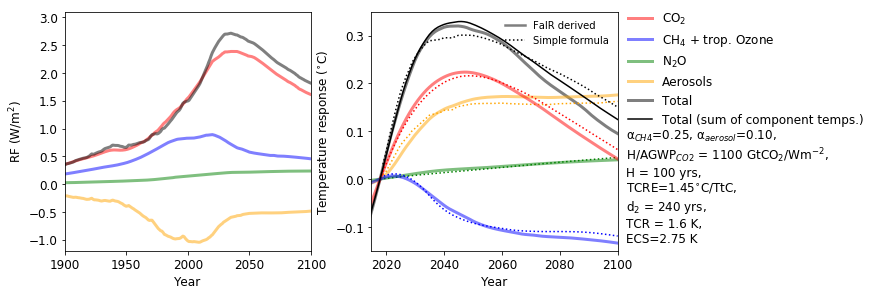

In [7]:
fig_mytechnique = plt.figure(figsize=(12,4))
ax_mytechnique = [0,0]
ax_mytechnique[0] = fig_mytechnique.add_axes([0.07, 0.13, 0.285, 0.83])
ax_mytechnique[1] = fig_mytechnique.add_axes([0.425, 0.13, 0.285, 0.83])
ax_mytechnique[0].set_xlabel('Year', fontsize=12)
ax_mytechnique[0].set_ylabel('RF (W/m$^2$)', fontsize=12)
ax_mytechnique[1].set_xlabel('Year', fontsize=12)
ax_mytechnique[1].set_ylabel('Temperature response ($^{\circ}$C)', fontsize=12)
ax_mytechnique[0].tick_params(labelsize=12)
ax_mytechnique[1].tick_params(labelsize=12)


ax_mytechnique[0].plot(np.arange(1765,2101), co2_rf_50_plushist, color='red', label='CO$_2$', linewidth=3, alpha=0.5)
ax_mytechnique[0].plot(np.arange(1765,2101), ch4_rf_50_plushist+tropOz_rf_50_plushist, color='blue', label='CH$_4$ + trop. Ozone', linewidth=3, alpha=0.5)
ax_mytechnique[0].plot(np.arange(1765,2101), n2o_rf_50_plushist, color='green', label='N$_2$O', linewidth=3, alpha=0.5)
# ax_mytechnique[0].plot(np.arange(1765,2101), fgases_rf_50_plushist, color='purple', label='F-Gases')
# ax_mytechnique[0].plot(np.arange(1765,2101), tropOz_rf_50_plushist, color='gold', label='trop. Ozone')
ax_mytechnique[0].plot(np.arange(1765,2101), aerosol_rf_50_plushist, color='orange', label='Aerosols', linewidth=3, alpha=0.5)
# ax_mytechnique[0].plot(np.arange(1765,2101), other_rf_50_plushist, color='brown', label='Other')
# ax_mytechnique[0].plot(np.arange(1765,2101), total_rf_50_plushist, color='black', label='Total')

ax_mytechnique[0].plot(np.arange(1765,2101), co2_rf_50_plushist + ch4_rf_50_plushist + n2o_rf_50_plushist + tropOz_rf_50_plushist + aerosol_rf_50_plushist, color='black', label='Total', linewidth=3, alpha=0.5)

T_combined_50 = fair_scm(other_rf=aerosol_rf_50_plushist+co2_rf_50_plushist+ch4_rf_50_plushist+n2o_rf_50_plushist+tropOz_rf_50_plushist)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_combined_50-T_combined_50[2018-1765], color='black', linewidth=3, alpha=0.5, label='Total RF with FaIRv1.0')

H = 100
TCRE = 1.45 # 1.45
AGWP_CO2 = H/1100. # 950
alpha = 0.25

# what we are aiming for
# T_ch4_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-ch4_rf_50_plushist)[1]
# ax_mytechnique[1].plot(np.arange(1765,2101), T_ch4_50-T_ch4_50[2018-1765], color='blue', linewidth=3, alpha=0.5, label='CH4 RF with FaIRv1.0')


# ch4_temperature_approx_frompresent = np.zeros(2101-1765)
# for i in range(2018-1765,2101-1765):
#     offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
#     ch4_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[i] - ch4_rf_50_plushist[2018-1765] + alpha*np.mean(ch4_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

# ax_mytechnique[1].plot(np.arange(2018,2101), ch4_temperature_approx_frompresent[2018-1765:], color='blue', linestyle=':', label='Stu Formula from present')





# T_fgases_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-fgases_rf_50_plushist)[1]
# ax_mytechnique[1].plot(np.arange(1765,2101), T_fgases_50-T_fgases_50[2018-1765], color='purple', linewidth=3, alpha=0.5, label='F-Gases RF with FaIRv1.0')


# fgases_temperature_approx_frompresent = np.zeros(2101-1765)
# for i in range(2018-1765,2101-1765):
#     offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
#     fgases_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(fgases_rf_50_plushist[i] - fgases_rf_50_plushist[2018-1765] + alpha*np.mean(fgases_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

# ax_mytechnique[1].plot(np.arange(2018,2101), fgases_temperature_approx_frompresent[2018-1765:], color='purple', linestyle=':', label='Stu Formula from present')





T_aerosol_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-aerosol_rf_50_plushist)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_aerosol_50-T_aerosol_50[2018-1765], color='orange', linewidth=3, alpha=0.5, label='Aerosol RF with FaIRv1.0')

alpha=0.1
aerosol_temperature_approx_frompresent = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
    aerosol_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(aerosol_rf_50_plushist[i] - aerosol_rf_50_plushist[2018-1765] + alpha*np.mean(aerosol_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

ax_mytechnique[1].plot(np.arange(2018,2101), aerosol_temperature_approx_frompresent[2018-1765:], color='orange', linestyle=':', label='Stu Formula from present')

alpha=0.25

# T_tropOz_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-tropOz_rf_50_plushist)[1]
# ax_mytechnique[1].plot(np.arange(1765,2101), T_tropOz_50-T_tropOz_50[2018-1765], color='gold', linewidth=3, alpha=0.5, label='tropOz RF with FaIRv1.0')


# tropOz_temperature_approx_frompresent = np.zeros(2101-1765)
# for i in range(2018-1765,2101-1765):
#     offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
#     tropOz_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(tropOz_rf_50_plushist[i] - tropOz_rf_50_plushist[2018-1765] + alpha*np.mean(tropOz_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

# ax_mytechnique[1].plot(np.arange(2018,2101), tropOz_temperature_approx_frompresent[2018-1765:], color='gold', linestyle=':', label='Stu Formula from present')



# T_other_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-other_rf_50_plushist)[1]
# ax_mytechnique[1].plot(np.arange(1765,2101), T_other_50-T_other_50[2018-1765], color='brown', linewidth=3, alpha=0.5, label='Other RF with FaIRv1.0')


# other_temperature_approx_frompresent = np.zeros(2101-1765)
# for i in range(2018-1765,2101-1765):
#     offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
#     other_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(other_rf_50_plushist[i] - other_rf_50_plushist[2018-1765] + alpha*np.mean(other_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

# ax_mytechnique[1].plot(np.arange(2018,2101), other_temperature_approx_frompresent[2018-1765:], color='brown', linestyle=':', label='Stu Formula from present')



T_n2o_50 = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist-n2o_rf_50_plushist*0.93)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_n2o_50-T_n2o_50[2018-1765], color='green', linewidth=3, alpha=0.5, label='N2O RF with FaIRv1.0')


n2o_temperature_approx_frompresent = np.zeros(2101-1765)
for i in range(2018-1765,2101-1765):
    offsets = 0.0 # TCRE*0.001*(12/44)*H*(1-alpha)*(ch4_rf_50_plushist[2018-1765] + alpha*np.sum(ch4_rf_50_plushist[:2019-1765])/(H*(1-alpha)))/AGWP_CO2
    
    n2o_temperature_approx_frompresent[i] = TCRE*0.001*(12/44)*H*(1-alpha)*(n2o_rf_50_plushist[i] - n2o_rf_50_plushist[2018-1765] + alpha*np.mean(n2o_rf_50_plushist[2019-1765:i+1])*(i-2018+1765)/(H*(1-alpha)))/AGWP_CO2 + offsets

# ax_mytechnique[1].plot(np.arange(2018,2101), n2o_temperature_approx_frompresent[2018-1765:], color='green', linestyle=':', label='Stu Formula from present')
# and as an LLCP (with GWP100)
n2o_temp_approx = (np.cumsum(n2o_ems_50_plushist)[2018-1765:] - np.sum(n2o_ems_50_plushist[:2019-1765]))*GWP_N2O*TCRE*(28/44)*12/44000000
ax_mytechnique[1].plot(np.arange(2018,2101), (np.cumsum(n2o_ems_50_plushist)[2018-1765:] - np.sum(n2o_ems_50_plushist[:2019-1765]))*GWP_N2O*TCRE*(28/44)*12/44000000, color='green', linestyle=':')



T_co2_50 = fair_scm(emissions=co2_ems_50_plushist*12/44000)[1]
ax_mytechnique[1].plot(np.arange(1765,2101), T_co2_50-T_co2_50[2018-1765], color='red', linewidth=3, alpha=0.5, label='CO2 RF with FaIRv1.0')
# as an LLCP
co2_temp_approx = (np.cumsum(co2_ems_50_plushist)[2018-1765:] - np.sum(co2_ems_50_plushist[:2019-1765]))*12/44000000*TCRE
ax_mytechnique[1].plot(np.arange(2018,2101), (np.cumsum(co2_ems_50_plushist)[2018-1765:] - np.sum(co2_ems_50_plushist[:2019-1765]))*12/44000000*TCRE, color='red', linestyle=':')






ch4_test = np.zeros_like(T_co2_50)
for i in range(2018-1765,2101-1765):
    
#     ch4_test[i] = (4*ch4_ems_15_interp[0,i] - 3.75*ch4_ems_15_interp[0,i-20])*GWP_CH4*12/44
    
    ch4_test[i] = ((1-alpha)*H*(ch4_ems_50_plushist[i] - ch4_ems_50_plushist[i-20])/20 + alpha*np.mean(ch4_ems_50_plushist[i-20:i]))*GWP_CH4*12/44 
    
#     E*(t) = ∑ [ E_LLCP(t) + 4 × E_SLCP(t) - 3.75×E_SLCP(t-20) ]

ax_mytechnique[1].plot(np.arange(2018,2101), np.cumsum(ch4_test)[2018-1765:]*TCRE*0.001, color='blue', linestyle=':')

ax_mytechnique[1].plot(np.arange(1765,2101), fair_scm(other_rf=ch4_rf_50_plushist+tropOz_rf_50_plushist)[1] - fair_scm(other_rf=ch4_rf_50_plushist+tropOz_rf_50_plushist)[1][2018-1765], color='blue', alpha=0.5, linewidth=3)


combined_ems_temp = np.cumsum(ch4_test)[2018-1765:]*TCRE*0.001 + (np.cumsum(co2_ems_50_plushist)[2018-1765:] - np.sum(co2_ems_50_plushist[:2019-1765]))*12/44000000*TCRE + (np.cumsum(n2o_ems_50_plushist)[2018-1765:] - np.sum(n2o_ems_50_plushist[:2019-1765]))*GWP_N2O*TCRE*(28/44)*12/44000000 + aerosol_temperature_approx_frompresent[2018-1765:]
combined_temp = fair_scm(other_rf=ch4_rf_50_plushist+tropOz_rf_50_plushist)[1] - fair_scm(other_rf=ch4_rf_50_plushist+tropOz_rf_50_plushist)[1][2018-1765] + T_co2_50 - T_co2_50[2018-1765] + T_n2o_50 - T_n2o_50[2018-1765] + T_aerosol_50 - T_aerosol_50[2018-1765]
ax_mytechnique[1].plot(np.arange(1765,2101), combined_temp, color='black', linestyle='-', label='Total (sum of component temps.)')
ax_mytechnique[0].plot([100], [100], color='black', linestyle='-', label='Total (sum of component temps.)')

ax_mytechnique[1].plot(np.arange(2018,2101), combined_ems_temp, color='black', linestyle=':')






# T_total_50 = fair_scm(other_rf=total_rf_50_plushist)[1]
# ax_mytechnique[1].plot(np.arange(1765,2101), T_total_50-T_total_50[2018-1765], color='black', linewidth=3, alpha=0.5, label='Total RF with FaIRv1.0')

# ax_mytechnique[1].plot(np.arange(2018,2101), co2_temp_approx+n2o_temp_approx+ch4_temperature_approx_frompresent[2018-1765:]+tropOz_temperature_approx_frompresent[2018-1765:]+aerosol_temperature_approx_frompresent[2018-1765:]+fgases_temperature_approx_frompresent[2018-1765:], color='black', linestyle=':') 

# ax_mytechnique[1].legend(loc='upper left', edgecolor='white', framealpha=0, fontsize=9)
ax_mytechnique[0].set_xlim(1900,2100) 
ax_mytechnique[0].set_ylim(-1.2,3.1)
ax_mytechnique[1].set_xlim(2015,2100)
ax_mytechnique[1].set_ylim(-0.15,0.35)
t = ax_mytechnique[1].text(2103,-0.13,'α$_{CH4}$=0.25, α$_{aerosol}$=0.10, \nH/AGWP$_{CO2}$ = 1100 GtCO$_2$/Wm$^{-2}$, \nH = 100 yrs, \nTCRE=1.45$^{\circ}$C/TtC, \nd$_2$ = 240 yrs, \nTCR = 1.6 K, \nECS=2.75 K', fontsize=12)

ax_mytechnique[0].legend(loc=(2.27,0.5), edgecolor='white', framealpha=0, fontsize=12)

legend_elements = [Line2D([0], [0], color='black', lw=2.5, label='FaIR derived', alpha=0.5),
                  Line2D([0], [0], color='black', lw=1.5, linestyle=':', label='Simple formula'),]

ax_mytechnique[1].legend(handles=legend_elements, loc='upper right', framealpha=0, edgecolor='none')

# fig_mytechnique.savefig('forcing_simpleFormula_2.pdf', dpi=300)

(2015, 2100)

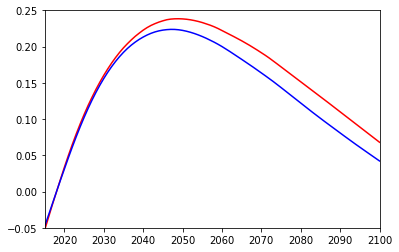

In [14]:
plt.plot(np.arange(1765,2101), (np.cumsum(co2_ems_50_plushist) - np.sum(co2_ems_50_plushist[:2019-1765]))*1.6*12/44000000, color='red')
plt.plot(np.arange(1765,2101), fair_scm(emissions=co2_ems_50_plushist*12/44000)[1] - fair_scm(emissions=co2_ems_50_plushist*12/44000)[1][2018-1765], color='blue')

plt.ylim(-0.05,0.25)
plt.xlim(2015,2100)

(2005, 2100)

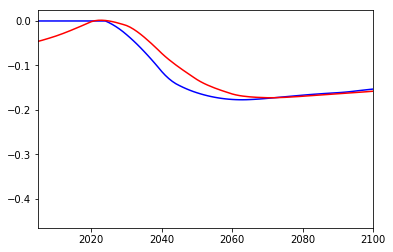

In [33]:
ch4_test = np.zeros(2101-2005)
alpha=0.25

for i in range(20,2101-2005):
    
#     ch4_test[i] = (4*ch4_ems_15_interp[0,i] - 3.75*ch4_ems_15_interp[0,i-20])*GWP_CH4*12/44
    
    ch4_test[i] = ((1-alpha)*H*(ch4_ems_15_interp[0,i] - ch4_ems_15_interp[0,i-20])/20 + alpha*np.mean(ch4_ems_15_interp[0,i-20:i]))*GWP_CH4*12/44 
    
#     E*(t) = ∑ [ E_LLCP(t) + 4 × E_SLCP(t) - 3.75×E_SLCP(t-20) ]

plt.plot(np.arange(2005,2101), np.cumsum(ch4_test)*1.4*0.001, color='blue')

ch4_rf_50_plushist_test = np.zeros(2101-1765)
ch4_rf_50_plushist_test[2005-1765:] = ch4_rf_15_interp[0,:]
ch4_rf_50_plushist_test[:2005-1765] = RCP85_E.CH4.loc[:2004].values * ch4_rf_15_interp[0,0] / RCP85_E.CH4.loc[2005]

ch4_temp_resp = fair_scm(other_rf=total_rf_50_plushist)[1] - fair_scm(other_rf=total_rf_50_plushist - ch4_rf_50_plushist_test*1.65)[1]
plt.plot(np.arange(1765,2101), ch4_temp_resp - ch4_temp_resp[2025-1765], color='red')

# cum_CH4 = np.zeros_like(ch4_test)
# for i in range(20,2101-2005):
# #     cum_CH4[i] = 75*np.mean(ch4_ems_15_interp[i-20:i]) + 0.25*np.sum(ch4_ems_15_interp[:i])
#     cum_CH4[i] = 4*np.sum(ch4_ems_15_interp[:i+1]) - 3.75*np.sum(ch4_ems_15_interp[:i-19])

# temp = cum_CH4*GWP_CH4*12/44*1.4*0.001

# plt.plot(np.arange(2005,2101), temp)
plt.xlim(2005,2100)
